In [110]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline

from auxiliary import get_base_network_name
import mpl_settings_v3
from mpl_settings_v3 import *
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler

net_dir = '../networks/ER'
fig_dir = '../draft/figs'

meank = 5
attack_dict = {
    'Ran': r'$\mathrm{Rnd}$', 'Deg': r'$\mathrm{ID}$', 'DegU': r'$\mathrm{RD}$',
    'Btw': r'$\mathrm{IB}$', 'BtwU': r'$\mathrm{RB}$', 
    'Eigenvector': r'$\mathrm{IE}$', 'EigenvectorU': r'$\mathrm{RE}$',
    'CI': r'$\mathrm{ICI}$', 'CIU': r'$\mathrm{RCI}$', 'CIU2': r'$\mathrm{RCI2}$',
    'BtwU_cutoff3': r'$\mathrm{RB3}$'
}

letters = [r'$\mathrm{(a)}$', r'$\mathrm{(b)}$', r'$\mathrm{(c)}$', r'$\mathrm{(d)}$',
           r'$\mathrm{(e)}$', r'$\mathrm{(f)}$', r'$\mathrm{(g)}$', r'$\mathrm{(h)}$']

attack_colors = {
    'B': '#27647b', 'D': '#ca3542', 'R': '#57575f', 'E': '#50C878',
    'C': '#80471C', # Brown peanut
    'B3': '#6F2DA8', # Purple
    'B4': '#F05E23' # Orange salamander
}

#attack_colors = {'B': '#27647b', 'D': '#ca3542', 'R': '#7b4609'}
#attack_colors = {'B': '#27647b', 'D': '#ca3542', 'R': '#c36e13'}

#c36e13 Orange
#7b4609 Brown
#57575f Grey
#attack_colors = {'B': colors[0], 'D': colors[1], 'R': '#57575f'}

In [100]:
def load_dataframe(attack, size, param, net_type='ER', fast=False, n_seeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    if fast:
        base_csv_file_name = '{}_nSeeds{:d}_cpp.csv'.format(attack, n_seeds)
    else:
        base_csv_file_name = '{}_cpp.csv'.format(attack)
    csv_file_name = os.path.join(dir_name, base_net_name, base_net_name_size, base_csv_file_name)
    df = pd.read_csv(csv_file_name, index_col=0)
    return df

def load_dfs(attack, N_values, meank):

    dfs100 = {}
    dfs1000 = {}
    dfs10000 = {}
    dfs20000 = {}
    dfs50000 = {}
    for N in N_values:
        try:
            dfs100[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=100)
        except:
            pass
        try:
            dfs1000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=1000)
        except:
            pass
        try:
            dfs10000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        except:
            pass
        try:
            dfs20000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=20000)
        except:
            pass
        try:
            dfs50000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=50000)
        except:
            pass

    dfsMax = {}
    for N in N_values:
        if N in dfs50000:
            dfsMax[N] = dfs50000[N]
        elif N in dfs20000:
            dfsMax[N] = dfs20000[N]
        elif N in dfs10000:
            dfsMax[N] = dfs10000[N]
        elif N in dfs1000:
            dfsMax[N] = dfs1000[N]
        else:
            dfsMax[N] = dfs100[N]
            
    return dfs1000, dfs10000, dfs20000, dfsMax

def compute_fc_v2(dfs, min_f, max_f, method='beta', only_next=False, verbose=False):

    N_values = sorted(list(dfs.keys()))
    
    
    N1_over_N2 = {}
    for N in N_values:
        if method == 'beta':
            N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            N1_over_N2[N] = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for i, Na in enumerate(N_values):
        for j, Nb in enumerate(N_values):
            if Nb <= Na:
                continue
            if only_next and j != i+1:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            if verbose:
                print(Na, Nb, inter+min_f, sep='\t')
            inter_values.append(inter)
    mean_inter = np.mean(inter_values)
    std_inter = np.std(inter_values)
    fc = min_f + mean_inter
    return fc, std_inter

def compute_crossings(dfs, min_f, max_f, method='beta', only_next=False, verbose=False):

    N_values = sorted(list(dfs.keys()))
        
    N1_over_N2 = {}
    for N in N_values:
        if method == 'beta':
            N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            N1_over_N2[N] = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for i, Na in enumerate(N_values):
        for j, Nb in enumerate(N_values):
            if Nb <= Na:
                continue
            if only_next and j != i+1:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            inter_values.append([Na, Nb, inter+min_f])
            print(Na, Nb, inter+min_f, sep='\t')
            
    return inter_values

from sklearn.linear_model import LinearRegression

def getPeaks(dfs, measure):
    N_values = sorted(dfs.keys())
    
    fc_values  = []
    max_values = []
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        max_idx = df[measure].idxmax()
        max_value = df[measure][max_idx]
        
        fc_values.append(max_idx/N)
        max_values.append(max_value)
        
    return fc_values, max_values

def get_critical_measures(dfs, measure, fc):
    
    N_values = sorted(dfs.keys())
    
    if fc == 'peak':
        fc_values, _ = getPeaks(dfs, measure)
    elif isinstance(fc, float): 
        fc_values = [fc] * len(N_values)
    else:
        print('ERROR')
        
    crit_values = []    
    for i, N in enumerate(N_values):
        df = dfs[N]
        fc = fc_values[i]
            
        if measure == 'Sgcc':
            crit_values.append(N*df[measure][int(fc*N)])
        else:
            crit_values.append(df[measure][int(fc*N)])
        
    return np.array(crit_values)  

def powerlaw(X, a, c):
    return c*np.array(X)**a

def getLinearReg(sizes, values, return_r2=False):

    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error

fontsize = 26

Deg	0.46524 +- 0.00007
DegU	0.34013 +- 0.00017
Btw	0.55381 +- 0.00251
BtwU	0.29838 +- 0.00033
Eigenvector	0.67732 +- 0.00133
EigenvectorU	0.31566 +- 0.00024
CIU	0.31742 +- 0.00077


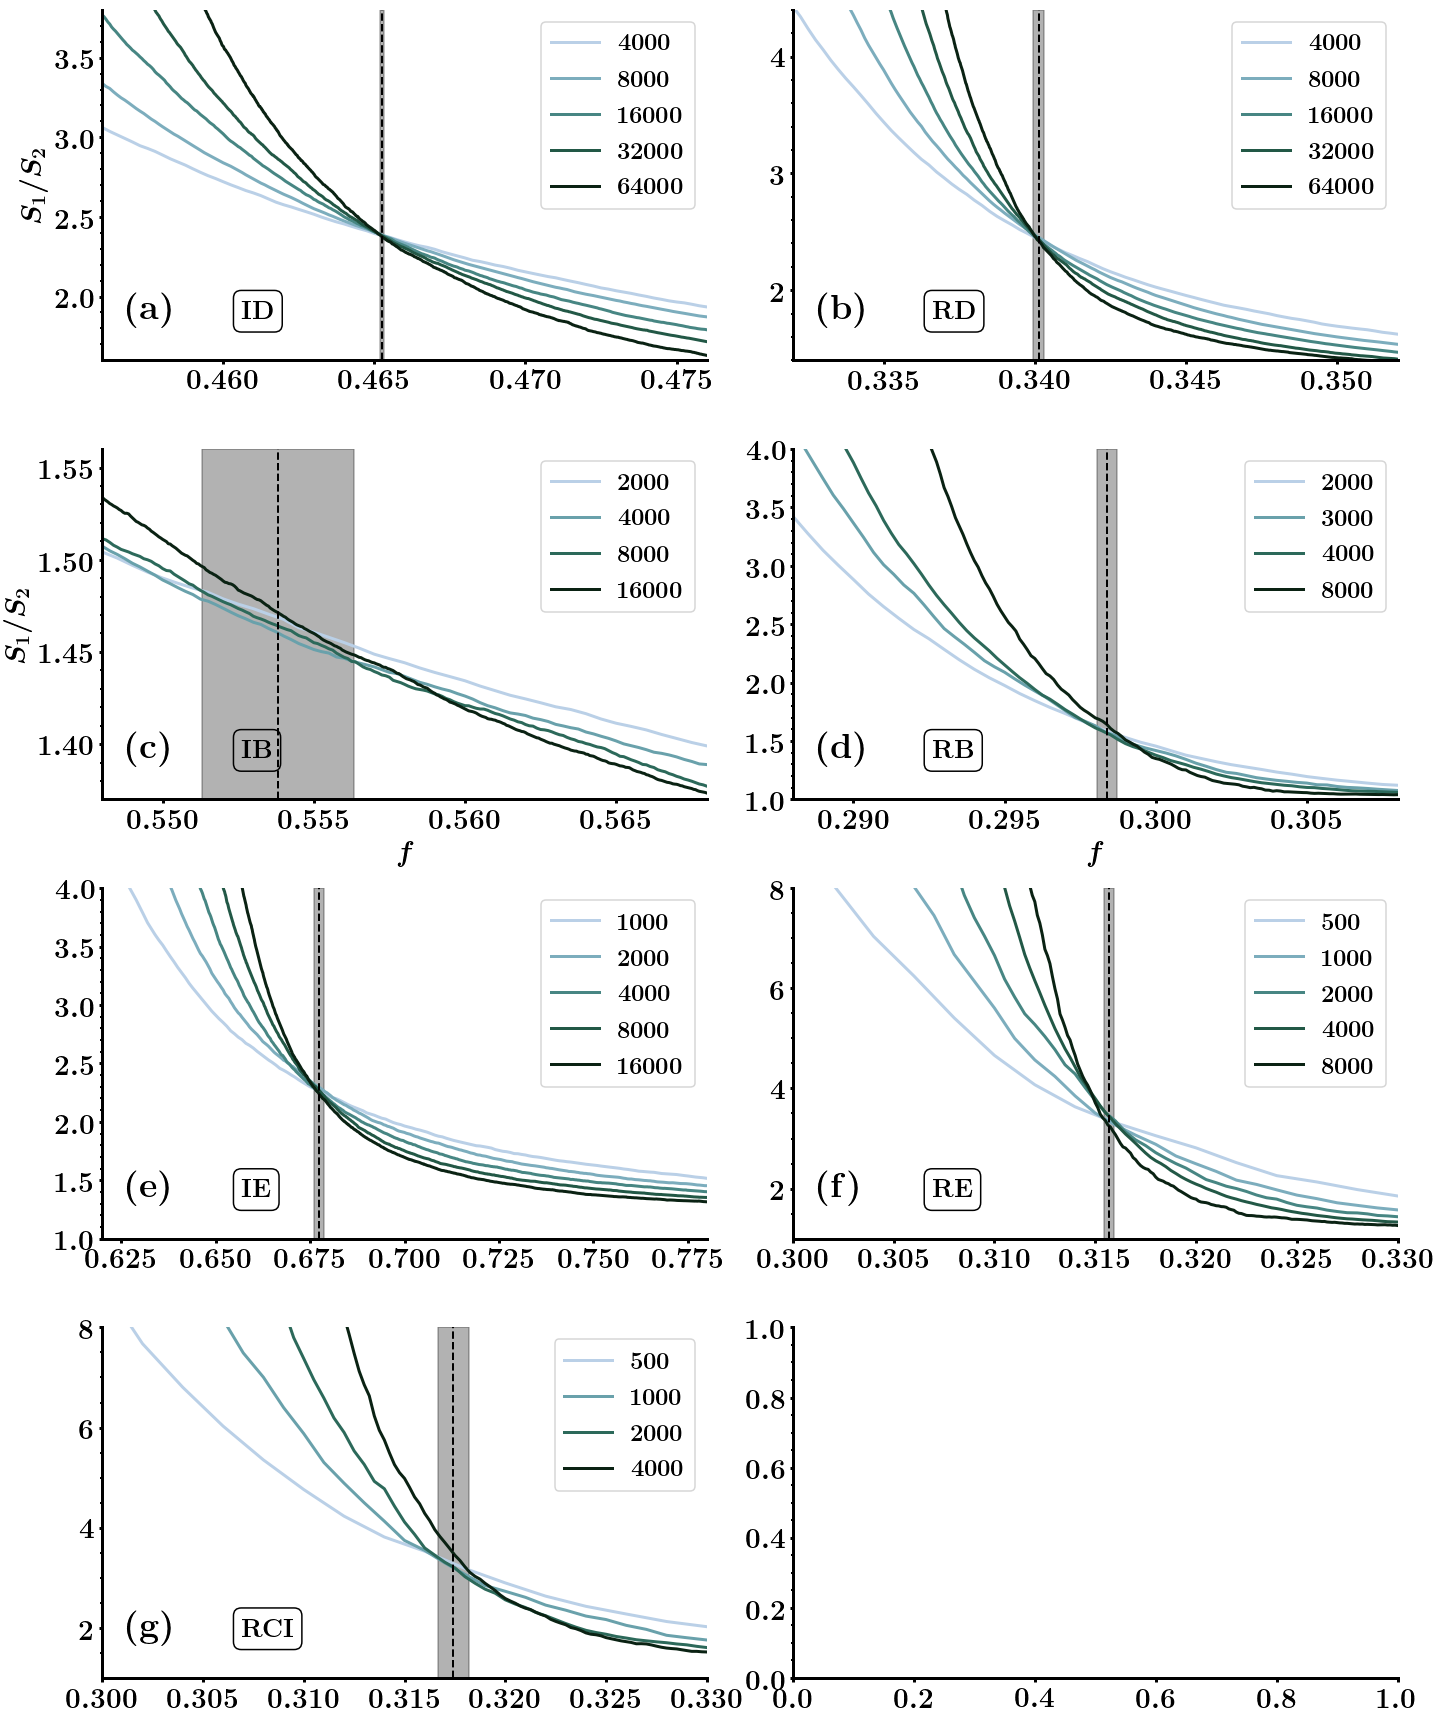

In [42]:
def plot_S1_over_S2():

    ncols = 2
    nrows = 4
    fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    attacks = ['Deg', 'DegU', 'Btw', 'BtwU', 'Eigenvector', 'EigenvectorU', 'CIU']
    for j, attack in enumerate(attacks):

        if attack == 'Deg':
            #N_values = [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000]
            N_values = [4000, 8000, 16000, 32000, 64000]
            fmin = 0.44
            fmax = 0.49
        elif attack == 'DegU':
            N_values = [4000, 8000, 16000, 32000, 64000]
            fmin = 0.334
            fmax = 0.345
        elif attack == 'Btw':
            #N_values = [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000]
            N_values = [2000, 4000, 8000, 16000]
            fmin = 0.5
            fmax = 0.6
        elif attack == 'BtwU':
            N_values = [2000, 3000, 4000, 8000]
            fmin = 0.28
            fmax = 0.32
        elif attack == 'Eigenvector':
            N_values = [1000, 2000, 4000, 8000, 16000]
            fmin = 0.62
            fmax = 0.78
        elif attack == 'EigenvectorU':
            N_values = [500, 1000, 2000, 4000, 8000]
            fmin = 0.3
            fmax = 0.33
        elif attack == 'CIU':
            N_values = [500, 1000, 2000, 4000]
            fmin = 0.3
            fmax = 0.33
    
        meank = 5
        _, _, _, dfs = load_dfs(attack, N_values, meank)
        
        ax = axes[j]
        if attack == 'Ran':
            fmin = 0.78
            fmax = 0.82
            ymin = 1.
            ymax = 5.

        if attack == 'Deg':
            fmin = 0.456
            fmax = 0.476
            ymin = 1.6
            ymax = 3.8        

        if attack == 'DegU':
            fmin = 0.332
            fmax = 0.352
            ymin = 1.4
            ymax = 4.4
            #ax.set_yticks([2, 2.3, 2.6, 2.9, 3.2])
            
        if attack == 'Btw':
            fmin = 0.548
            #fmin = 0.54
            fmax = 0.568
            ymin = 1.37
            ymax = 1.56
            #ax.set_yticks([1.4, 1.5, 1.6])  
            
        if attack == 'BtwU':
            fmin = 0.288
            fmax = 0.308
            ymin = 1.
            ymax = 4.0
            
        if attack == 'EigenvectorU':
            fmin = 0.3
            fmax = 0.33
            ymin = 1.
            ymax = 8.0
            
        if attack == 'CIU':
            fmin = 0.3
            fmax = 0.33
            ymin = 1.
            ymax = 8.0
            
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(fmin, fmax)
        
        if j in [0, 2]:
            #ax.set_ylabel(r'$S_1(f, N)/S_2(f, N)$')
            ax.set_ylabel(r'$S_1/S_2$', fontsize=28)
        if j in [2, 3]:
            ax.set_xlabel(r'$f$', fontsize=28)

        _N_values = list(dfs.keys())
        colors = sns.cubehelix_palette(len(_N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
        for i, N in enumerate(_N_values):

            df = dfs[N]
            S1_over_S2 = N * df.Sgcc / df.Nsec
            ax.plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])


        mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False)
        print('{}\t{:.5f} +- {:.5f}'.format(attack, mean_fc, std_fc))
        
        ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
        ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        #ax.text(0.1, 0.1, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
        ax.text(0.23, 0.12, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        ax.text(0.04, 0.12, letters[j], fontsize=36, transform=ax.transAxes, 
                horizontalalignment='left')
        ax.legend(loc='best', fontsize=24)

    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'crossing_method')
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    
    plt.show()
    
plot_S1_over_S2()

Deg	0.46496 +- 0.00006
DegU	0.33991 +- 0.00006
Btw	0.55676 +- 0.00253
BtwU	0.29684 +- 0.00031


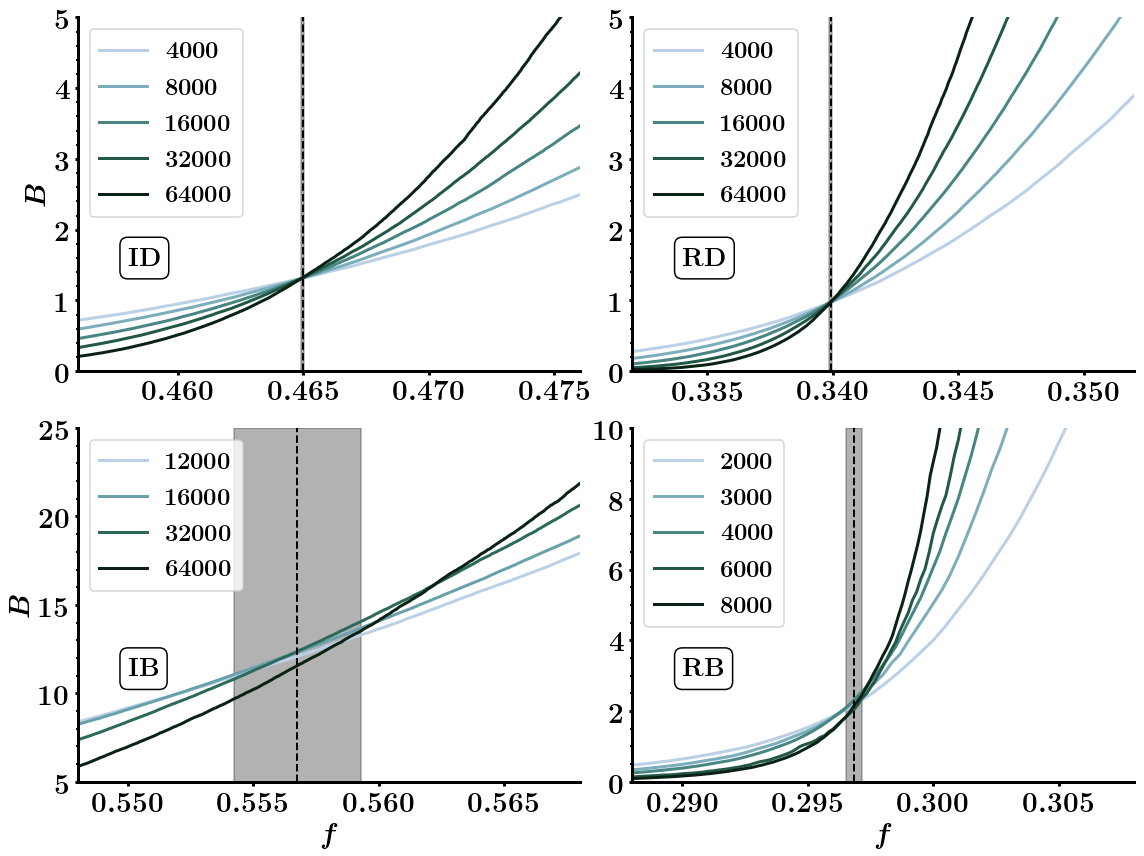

In [61]:
def plot_Binder():

    ncols = 2
    nrows = 2
    fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
    for j, attack in enumerate(attacks):
        
        if attack == 'Ran':
            N_values = [4000, 8000, 16000, 32000, 64000]
            fc_theo = 0.800
            fmin = 0.78
            fmax = 0.82
        elif attack == 'Deg':
            #N_values = [8000, 12000, 16000, 32000, 64000]
            N_values = [4000, 8000, 16000, 32000, 64000]
            fc_theo = 0.4653
            fmin = 0.44
            fmax = 0.49
        elif attack == 'DegU':
            N_values = [4000, 8000, 16000, 32000, 64000]
            fc_theo = 0.3395
            fmin = 0.334
            fmax = 0.345
        elif attack == 'Btw':
            N_values = [12000, 16000, 32000, 64000]
            fc_theo = 0.55
            tolerance = fc_theo/500
            fmin = 0.5
            fmax = 0.6
        elif attack == 'BtwU':
            N_values = [2000, 3000, 4000, 6000, 8000]
            fc_theo = 0.3
            tolerance = fc_theo/500
            fmin = 0.28
            fmax = 0.32
    
        meank = 5
        _, _, _, dfs = load_dfs(attack, N_values, meank)
        
        ax = axes[j]

        if attack == 'Deg':
            fmin = 0.456
            fmax = 0.476
            ymin = 0
            ymax = 5       

        if attack == 'DegU':
            fmin = 0.332
            fmax = 0.352
            ymin = 0
            ymax = 5
            #ax.set_yticks([2, 2.3, 2.6, 2.9, 3.2])
            
        if attack == 'Btw':
            fmin = 0.548
            fmax = 0.568
            ymin = 5
            ymax = 25
            #ax.set_yticks([1.4, 1.5, 1.6])  
            
        if attack == 'BtwU':
            fmin = 0.288
            fmax = 0.308
            ymin = 0
            ymax = 10
            
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(fmin, fmax)
        
        if j in [0, 2]:
            #ax.set_ylabel(r'$S_1(f, N)/S_2(f, N)$')
            ax.set_ylabel(r'$B$', fontsize=28)
        if j in [2, 3]:
            ax.set_xlabel(r'$f$', fontsize=28)

        _N_values = list(dfs.keys())
        colors = sns.cubehelix_palette(len(_N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
        for i, N in enumerate(_N_values):

            df = dfs[N]
            B = df.meanS / (N*df.Sgcc**2)
            ax.plot(df.f, B, '-', label=r'${{{}}}$'.format(N), color=colors[i])


        mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, method='binder')
        print('{}\t{:.5f} +- {:.5f}'.format(attack, mean_fc, std_fc))
        
        ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
        ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.1, 0.3, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        ax.legend(loc='best', fontsize=24)

    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'crossing_method_Binder')
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    
    plt.show()
    
plot_Binder()

/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


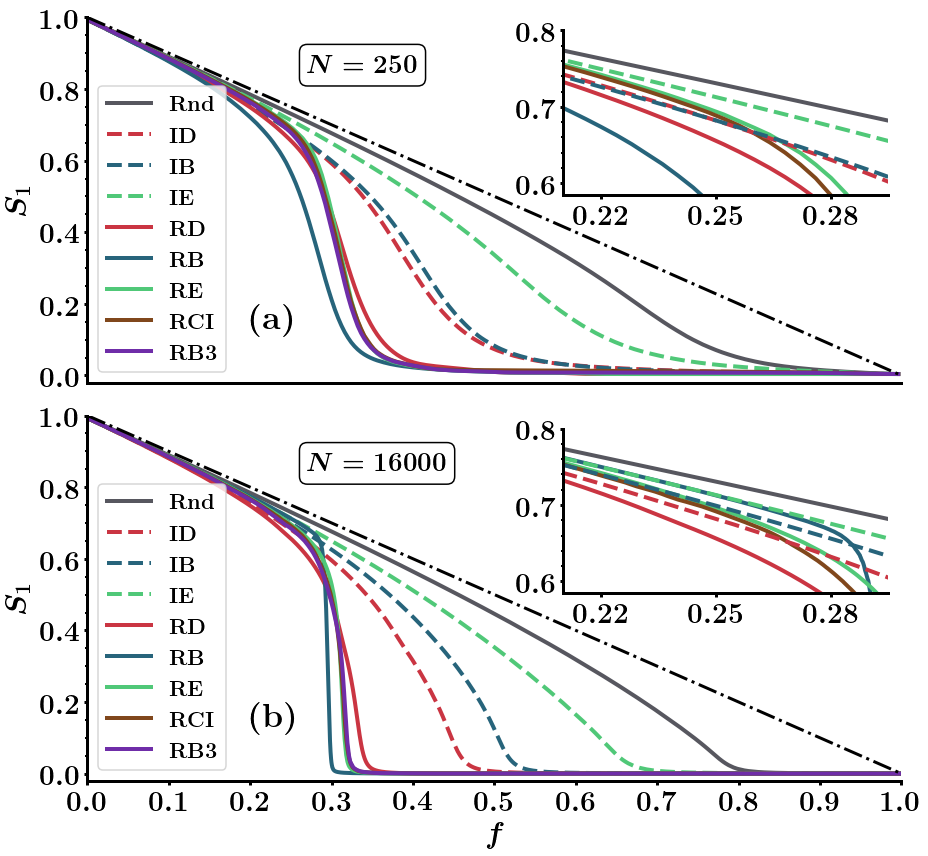

In [103]:
def plot_fig_order_param(dfs, N_values, inset=False):
    
    ncols = 1
    nrows = 2
    fig, axes = plt.subplots(figsize=(13*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    for i, N in enumerate(N_values):
        ax = axes[i]
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel(r'$S_1$')
        if i == 1:
            ax.set_xlabel(r'$f$')
        X = np.arange(N) / N
        Y1 = dfs['BtwU'][N]['Sgcc'] 
        Y2 = dfs['DegU'][N]['Sgcc']
        Y4 = dfs['Btw'][N]['Sgcc'] 
        Y5 = dfs['Deg'][N]['Sgcc']
        Y3 = dfs['Ran'][N]['Sgcc']
        Y6 = dfs['Eigenvector'][N]['Sgcc']
        Y7 = dfs['EigenvectorU'][N]['Sgcc']
        #Y8 = dfs['CI'][N]['Sgcc']
        Y9 = dfs['CIU'][N]['Sgcc']
        Y10 = dfs['BtwU_cutoff3'][N]['Sgcc']
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.02, 1)
        if i == 1:
            ax.set_xticks(np.arange(0, 1.1, 0.1))
        else:
            ax.set_xticks([])
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.plot(X, Y3, label=r'$\mathrm{Rnd}$', color=attack_colors['R'], linewidth=4)
        ax.plot(X, Y5, label=r'$\mathrm{ID}$', color=attack_colors['D'], linewidth=4, linestyle='--')
        ax.plot(X, Y4, label=r'$\mathrm{IB}$', color=attack_colors['B'], linewidth=4, linestyle='--')
        ax.plot(X, Y6, label=r'$\mathrm{IE}$', color=attack_colors['E'], linewidth=4, linestyle='--')
        #ax.plot(X, Y8, label=r'$\mathrm{RCI}$', color=attack_colors['C'], linewidth=4, linestyle='--')
        ax.plot(X, Y2, label=r'$\mathrm{RD}$', color=attack_colors['D'], linewidth=4)
        ax.plot(X, Y1, label=r'$\mathrm{RB}$', color=attack_colors['B'], linewidth=4)
        ax.plot(X, Y7, label=r'$\mathrm{RE}$', color=attack_colors['E'], linewidth=4)
        ax.plot(X, Y9, label=r'$\mathrm{RCI}$', color=attack_colors['C'], linewidth=4)
        ax.plot(X, Y10, label=r'$\mathrm{RB3}$', color=attack_colors['B3'], linewidth=4)
        ax.plot(X, 1 - X, color='k', linestyle='-.')

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        if inset:
            ax.text(0.27, 0.85, r'$N = {{{:d}}}$'.format(N), fontsize=26, transform=ax.transAxes, bbox=bbox)
        else:
            ax.text(0.7, 0.45, r'$N\; = {{{:d}}}$'.format(N) + '\n' + r'$\langle k \rangle=4$', 
                    fontsize=26, transform=ax.transAxes, bbox=bbox)

            
        ax.text(0.2, 0.15, letters[i], fontsize=34, transform=ax.transAxes, 
                horizontalalignment='left')
        ax.legend(loc='lower left', fontsize=22)

        if inset:
            bbox_to_anchor = (.6, .55, .4, .45)
            axins = inset_axes(ax, width="100%", height="100%",
                    bbox_to_anchor=bbox_to_anchor,
                    bbox_transform=ax.transAxes)
            axins.spines['right'].set_visible(False)
            axins.spines['top'].set_visible(False)
            
            ## For meank = 4
            #axins.set_xlim(0.14, 0.217)
            #axins.set_ylim(0.585, 0.83)
            #axins.set_xticks([0.15, 0.18, 0.21])
            #axins.set_yticks([0.6, 0.7, 0.8])
            
            ## For meank = 5
            axins.set_xlim(0.21, 0.295)
            axins.set_ylim(0.585, 0.77)
            axins.set_xticks([0.22, 0.25, 0.28])
            axins.set_yticks([0.6, 0.7, 0.8])
            axins.plot(X, Y3, color=attack_colors['R'], linewidth=4)
            axins.plot(X, Y2, color=attack_colors['D'], linewidth=4)
            axins.plot(X, Y1, color=attack_colors['B'], linewidth=4)
            axins.plot(X, Y7, color=attack_colors['E'], linewidth=4)
            axins.plot(X, Y9, color=attack_colors['C'], linewidth=4)
            axins.plot(X, Y5, color=attack_colors['D'], linewidth=4, linestyle='--')
            axins.plot(X, Y4, color=attack_colors['B'], linewidth=4, linestyle='--')
            axins.plot(X, Y6, color=attack_colors['E'], linewidth=4, linestyle='--')
            #axins.plot(X, Y8, color=attack_colors['C'], linewidth=4, linestyle='--')
    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'percolation_two_sizes')
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    plt.show()
    
meank = 5
N_values = [250, 8000]
dfs = {}
attacks = ['Ran', 'Deg', 'DegU', 'Btw', 'BtwU', 'Eigenvector', 'EigenvectorU', 'CIU', 'BtwU_cutoff3']
for attack in attacks:
    
    _, _, _, _dfs = load_dfs(attack, N_values, meank)    
    dfs[attack] = _dfs
plot_fig_order_param(dfs, N_values, inset=True)

Ran
Deg
DegU
Btw
BtwU
Eigenvector
EigenvectorU
CIU
CIU2
BtwU_cutoff2
BtwU_cutoff3
BtwU_cutoff4


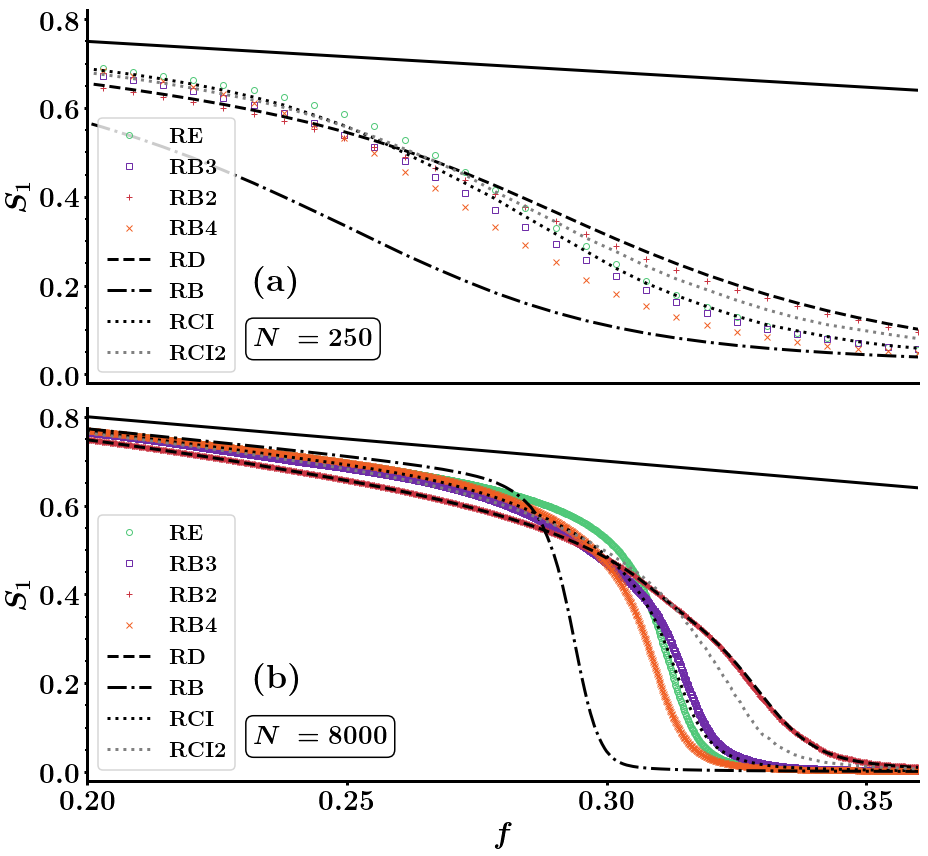

In [117]:
def plot_fig_order_param(dfs, N_values, inset=False):
    
    
    
    ncols = 1
    nrows = 2
    fig, axes = plt.subplots(figsize=(13*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    for i, N in enumerate(N_values):
        ax = axes[i]
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel(r'$S_1$')
        if i == 1:
            ax.set_xlabel(r'$f$')
        X = np.arange(N) / N
        Y1 = dfs['BtwU'][N]['Sgcc'] 
        Y2 = dfs['DegU'][N]['Sgcc']
        Y4 = dfs['Btw'][N]['Sgcc'] 
        Y5 = dfs['Deg'][N]['Sgcc']
        Y3 = dfs['Ran'][N]['Sgcc']
        Y6 = dfs['Eigenvector'][N]['Sgcc']
        Y7 = dfs['EigenvectorU'][N]['Sgcc']
        #Y8 = dfs['CI'][N]['Sgcc']
        Y9 = dfs['CIU'][N]['Sgcc']
        Y13 = dfs['CIU2'][N]['Sgcc']
        Y10 = dfs['BtwU_cutoff3'][N]['Sgcc']
        Y11 = dfs['BtwU_cutoff2'][N]['Sgcc']
        Y12 = dfs['BtwU_cutoff4'][N]['Sgcc']
        ax.set_xlim(0.25, 0.36)
        ax.set_ylim(-0.02, 0.82)
        if i == 1:
            ax.set_xticks(np.arange(0.2, 0.4, 0.05))
        else:
            ax.set_xticks([])
        #ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.set_prop_cycle(marker=['o', 's', '+', 'x', '^', '*', '.'])
        #ax.plot(X, Y3, '.', label=r'$\mathrm{Rnd}$', color=attack_colors['R'], linewidth=4)
        #ax.plot(X, Y2, label=r'$\mathrm{RD}$', color=attack_colors['D'], linestyle='', fillstyle='none')
        
        #ax.plot(X, Y1, label=r'$\mathrm{RB}$', color=attack_colors['B'], linestyle='', fillstyle='none')
        
        ax.plot(X, Y7, label=r'$\mathrm{RE}$', color=attack_colors['E'], linestyle='', fillstyle='none')
        #ax.plot(X, Y9, label=r'$\mathrm{RCI}$', color=attack_colors['C'], linestyle='', fillstyle='none')
        
        ax.plot(X, Y10, label=r'$\mathrm{RB3}$', color=attack_colors['B3'], linestyle='', fillstyle='none')
        ax.plot(X, Y11, label=r'$\mathrm{RB2}$', color=attack_colors['D'], linestyle='', fillstyle='none')
        ax.plot(X, Y12, label=r'$\mathrm{RB4}$', color=attack_colors['B4'], linestyle='', fillstyle='none')
        
        ax.plot(X, Y2, label=r'$\mathrm{RD}$', color='k', linestyle='--', marker='', linewidth=3)
        ax.plot(X, Y1, label=r'$\mathrm{RB}$', color='k', linestyle='-.', marker='', linewidth=3)
        ax.plot(X, Y9, label=r'$\mathrm{RCI}$', color='k', linestyle=':', marker='', linewidth=3)
        ax.plot(X, Y13, label=r'$\mathrm{RCI2}$', color='grey', linestyle=':', marker='', linewidth=3)
        ax.plot(X, 1 - X, color='k', linestyle='-', marker='')

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.2, 0.1, r'$N\; = {{{:d}}}$'.format(N), 
                    fontsize=26, transform=ax.transAxes, bbox=bbox)

            
        ax.text(0.2, 0.25, letters[i], fontsize=34, transform=ax.transAxes, 
                horizontalalignment='left')
        ax.legend(loc='lower left', fontsize=22)

    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'percolation_two_sizes_new')
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    plt.show()
    
meank = 5
N_values = [250, 8000]
dfs = {}
attacks = [
    'Ran', 'Deg', 'DegU', 'Btw', 'BtwU', 'Eigenvector', 'EigenvectorU', 'CIU', 'CIU2',
    'BtwU_cutoff2', 'BtwU_cutoff3', 'BtwU_cutoff4'
]
for attack in attacks:
    print(attack)
    _, _, _, _dfs = load_dfs(attack, N_values, meank)    
    dfs[attack] = _dfs
plot_fig_order_param(dfs, N_values, inset=True)

In [ ]:
attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
all_comp_sizes_dict = {}
comp_dist_log = {}
for attack in attacks:
    comp_dist_log[attack] = {}

In [146]:
N_per_attack = {
    'Deg':  64000,
    'DegU': 64000,
    'Btw':  64000,
    'BtwU': 16000,
}
#for attack in attacks:
for attack in ['Btw']:
    N = N_per_attack[attack]
    all_comp_sizes_dict[attack][N] = {}   
    comp_dist_log[attack][N] = {}

In [147]:
overwrite = False
attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
all_f_values = {
    #'Deg':  ['0.2', '0.4', '0.4538', '0.5', '0.7'], ## N = 16000
    'Deg':  ['0.2', '0.4', '0.4583', '0.5', '0.7'], ##['0.45834375'], ## N = 64000
    #'DegU': ['0.2', '0.3', '0.3356', '0.37', '0.4'], ## N = 16000
    'DegU': ['0.2', '0.3', '0.3370', '0.37', '0.4'], ## N = 64000
    #'DegU': ['0.33696875'], ## N = 64000
    #'Btw':  ['0.35', '0.45', '0.5149', '0.65', '0.75'], ## N = 16000
    'Btw':  ['0.35', '0.45', '0.5293', '0.65', '0.75'], ## N = 64000
    #'Btw':  ['0.52934375'], ## N = 64000
    'BtwU': [ '0.2', '0.28', '0.2956', '0.31', '0.35'] ## N = 16000
}

for attack in attacks:
    print(attack)
    N = N_per_attack[attack]
    f_values = all_f_values[attack]
    
    net_dir_name = '../networks/ER/ER_k{:.2f}'.format(meank)
    base_net_name = 'ER_k{:.2f}_N{}'.format(meank, N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)

    for f_value in f_values:
        print(f_value)
        """
        file_name = 'comp_sizes_{}_f{}'.format(attack, f_value)
        full_file_name = os.path.join(data_dir, file_name)
        if os.path.isfile(full_file_name + '.npy') and not overwrite:
            comp_sizes = np.load(full_file_name + '.npy')
        else:
            comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
            print('Loading file', file_name)
            full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
            comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
            np.save(full_file_name, comp_sizes)
        """
        if f_value in all_comp_sizes_dict[attack][N]:
            continue
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
        comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
        
        all_comp_sizes_dict[attack][N][f_value] = comp_sizes

Deg
0.2
0.4
0.4583
0.5
0.7
DegU
0.2
0.3
0.3370
0.37
0.4
Btw
0.35
0.45
0.5293
0.65
0.75
BtwU
0.2
0.28
0.2956
0.31
0.35


-2.503155079934317 0.018434564441977122
-2.4270510364196656 0.028037862593911864
-2.515517922696691 0.024170831249647345


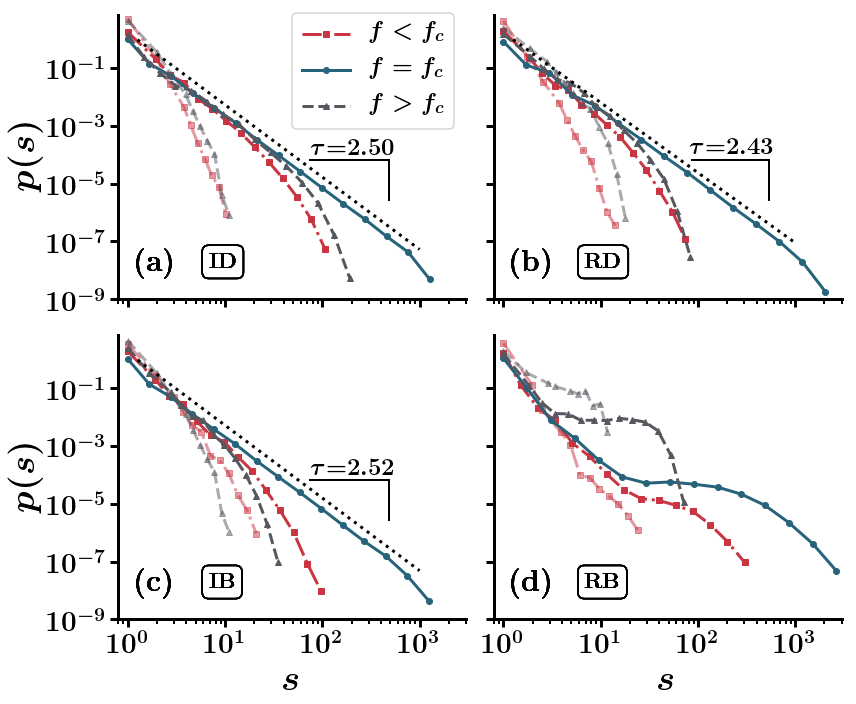

In [156]:
def powerlaw(X, a, c):
    return c*X**(-a)

def _getLinearReg(sizes, values, return_r2=False):
    linear_regressor = LinearRegression() 
    X = np.log(sizes).reshape(-1, 1)
    Y = np.log(values).reshape(-1, 1)
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    slope = linear_regressor.coef_[0][0]
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope

def plot_comp_distribution(all_f_values):
    
    attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
    
    def get_histo(comp_sizes):
        mask = comp_sizes > 0
        comp_sizes = comp_sizes[mask]     
        min_s = np.min(comp_sizes)
        max_s = np.max(comp_sizes)
        bins = np.logspace(np.log10(min_s), np.log10(max_s), 16)
        hist = np.histogram(comp_sizes, bins=bins, density=True)
        hist_norm = hist[0]
        hist_norm[hist_norm==0] = np.NaN
        mask = ~np.isnan(hist_norm)
        X = bins[:-1]
        X = X[mask]
        Y = hist_norm[mask]

        return X, Y

    def plot_five_values(attack, comp_sizes, f_values, ax):
        for i, f_value in enumerate(f_values):
            X, Y = get_histo(comp_sizes[f_value])
            
            if True:
            
                if i == 0:
                    ax.plot(X, Y, '-.', marker='s', color=_colors[0], alpha=0.5)
                if i == 1:
                    ax.plot(X, Y, '-.', marker='s', color=_colors[0], label=r'$f<f_c$')
                if i == 2:
                    ax.plot(X, Y, '-' , marker='o', color=_colors[1], label=r'$f=f_c$')
                if i == 3:
                    ax.plot(X, Y, '--', marker='^', color=_colors[2], label=r'$f>f_c$')
                if i == 4:
                    ax.plot(X, Y, '--', marker='^', color=_colors[2], alpha=0.5)
            else:
                ax.plot(X, Y, '-' , marker='o', color=_colors[1], label=r'$f=f_c$')
                
            bbox = {'boxstyle': 'round', 'fc': 'None'}
            #ax.text(0.9, 0.85, attack_dict[attack], fontsize=20, 
            ax.text(0.26, 0.11, attack_dict[attack], fontsize=22, 
                    transform=ax.transAxes, bbox=bbox, horizontalalignment='left')
            ax.text(0.05, 0.1, letters[attacks.index(attack)], fontsize=30, 
                    transform=ax.transAxes, horizontalalignment='left')
        
            if i == 2 or len(f_values) < 2:
                if attack == 'Btw':
                    Y_pred, slope, y_err = getLinearReg(X[:-2], Y[:-2], return_r2=False)
                else:
                    Y_pred, slope, y_err = getLinearReg(X[:-1], Y[:-1], return_r2=False)
        
        return Y_pred, slope, y_err/3
            
    
    _colors = ['#ca3542', '#27647b', '#57575f']
    ylim = (1E-9, 7)
    xlim = (0.8, 3000)
    ncols = 2
    nrows = 2
    fig, all_axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

    
    for ax in all_axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='major', length=8)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    for ax in all_axes[1,:]:
        ax.set_xlabel(r'$s$', fontsize=36)
    for ax in all_axes[:,0]:
        ax.set_ylabel(r'$p(s)$', fontsize=36)    

    attack = 'Deg'
    N = N_per_attack[attack]
    ax = all_axes[0,0]
    ax.set_xticklabels([])

    f_values = all_f_values[attack]
    Y_pred, slope, r2 = plot_five_values(attack, all_comp_sizes_dict[attack][N], f_values, ax)
    print(slope, r2)

    tau = -slope
    X = np.logspace(0.1, 3, 100)
    Y = powerlaw(X, tau, 1.7)

    ax.plot(X, Y, ':', color='k')
    ax.legend(loc=(0.5,0.6), fontsize=24)
    
    ax.text(0.55, 0.51, r'$\tau$' + r'$=$' + r'${{{:.2f}}}$'.format(tau), 
            transform=ax.transAxes, fontsize=24)
    line = ax.axhline(0.49, 0.55, 0.78, color='k', linewidth=2)
    line.set_transform(ax.transAxes)
    line = ax.axvline(0.78, 0.49, 0.35, color='k', linewidth=2)
    line.set_transform(ax.transAxes)

    attack = 'DegU'
    N = N_per_attack[attack]
    ax = all_axes[0, 1]

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    f_values = all_f_values[attack]
    Y_pred, slope, r2 = plot_five_values(attack, all_comp_sizes_dict[attack][N], f_values, ax)
    print(slope, r2)
    tau = -slope
    X = np.logspace(0.1, 3, 100)
    Y = powerlaw(X, tau, 1.7)
    ax.plot(X, Y, ':', color='k', label=r'$\tau$')
    
    ax.text(0.56, 0.51, r'$\tau$' + r'$=$' + r'${{{:.2f}}}$'.format(tau), 
            transform=ax.transAxes, fontsize=24)
    line = ax.axhline(0.49, 0.57, 0.79, color='k', linewidth=2)
    line.set_transform(ax.transAxes)
    line = ax.axvline(0.79, 0.49, 0.35, color='k', linewidth=2)
    line.set_transform(ax.transAxes)

    attack = 'Btw'
    N = N_per_attack[attack]
    ax = all_axes[1,0]
    f_values = all_f_values[attack]

    Y_pred, slope, r2 = plot_five_values(attack, all_comp_sizes_dict[attack][N], f_values, ax)
    print(slope, r2)
    tau = -slope
    X = np.logspace(0.1, 3, 100)
    Y = powerlaw(X, tau, 1.7)
    ax.plot(X, Y, ':', color='k', label=r'$\tau$')
    
    ax.text(0.55, 0.51, r'$\tau$' + r'$=$' + r'${{{:.2f}}}$'.format(tau), 
            transform=ax.transAxes, fontsize=24)
    line = ax.axhline(0.49, 0.55, 0.78, color='k', linewidth=2)
    line.set_transform(ax.transAxes)
    line = ax.axvline(0.78, 0.49, 0.35, color='k', linewidth=2)
    line.set_transform(ax.transAxes)


    attack = 'BtwU'
    N = N_per_attack[attack]
    ax = all_axes[1,1]
    ax.set_yticklabels([])
    f_values = all_f_values[attack]
    plot_five_values(attack, all_comp_sizes_dict[attack][N], f_values, ax)
    tau = 2.1
    X = np.logspace(0.1, 3, 100)
    Y = powerlaw(X, tau, 1.7)
    #ax.plot(X, Y, ':', color='k', label=r'$\tau$')

    
    plt.tight_layout()
    fig_name = os.path.join(fig_dir, 'comp_sizes')
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')

    plt.show()
    
plot_comp_distribution(all_f_values)

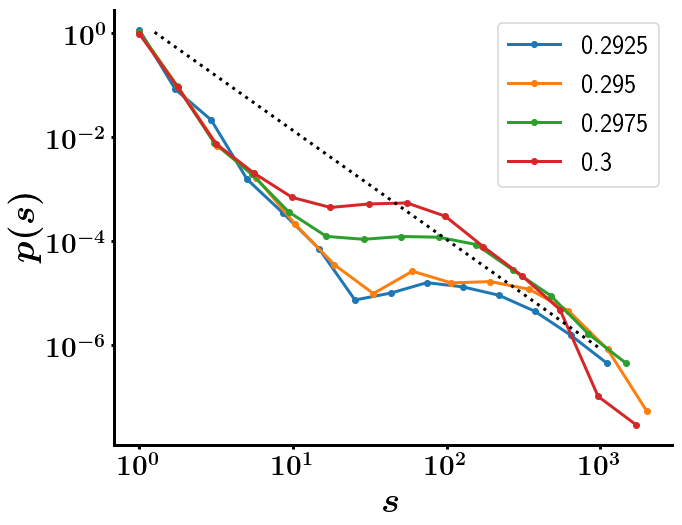

In [254]:
def plot_comp_distribution_BtwU(f_values, comp_sizes):
    
    def get_histo(comp_sizes):
        mask = comp_sizes > 0
        comp_sizes = comp_sizes[mask]     
        min_s = np.min(comp_sizes)
        max_s = np.max(comp_sizes)
        bins = np.logspace(np.log10(min_s), np.log10(max_s), 15)
        hist = np.histogram(comp_sizes, bins=bins, density=True)
        hist_norm = hist[0]
        hist_norm[hist_norm==0] = np.NaN
        mask = ~np.isnan(hist_norm)
        X = bins[:-1]
        X = X[mask]
        Y = hist_norm[mask]

        return X, Y

    def plot_five_values(attack, comp_sizes, f_values, ax):
        for i, f_value in enumerate(f_values):
            X, Y = get_histo(comp_sizes[f_value])
            ax.plot(X, Y, '-' , marker='o', label=f_value)
            if i == 2 or len(f_values) < 2:
                Y_pred, slope, r2 = getLinearReg(X[:-2], Y[:-2], return_r2=True)
        
        return Y_pred, slope, r2

    ncols = 1
    nrows = 1
    fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$s$', fontsize=36)
    ax.set_ylabel(r'$p(s)$', fontsize=36)    

    tau = -slope
    plot_five_values(attack, comp_sizes, f_values, ax)
    tau = 2.1
    X = np.logspace(0.1, 3, 100)
    Y = powerlaw(X, tau, 1.7)
    ax.plot(X, Y, ':', color='k')
    ax.legend()
    plt.show()


attack = 'BtwU'
N = 16000
comp_sizes_BtwU = {}
#f_values = ['0.29', '0.295', '0.3', '0.305', '0.31']
#f_values = ['0.285', '0.29', '0.295', '0.3']
f_values = ['0.2925', '0.295', '0.2975', '0.3']

net_dir_name = '../networks/ER/ER_k{:.2f}'.format(meank)
base_net_name = 'ER_k{:.2f}_N{}'.format(meank, N)
base_net_dir_name = os.path.join(net_dir_name, base_net_name)

for f_value in f_values:
    comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    comp_sizes_BtwU[f_value] = comp_sizes
        
plot_comp_distribution_BtwU(f_values, comp_sizes_BtwU)

attack		beta/nu gamma/nu      1  delta_1     tau delta_tau
Deg       	0.3192    0.3543 0.9927   0.0103  2.4739    0.0120
DegU      	0.3072    0.3773 0.9916   0.0160  2.4488    0.0177
Btw       	0.3388    0.3365 1.0141   0.0141  2.5017    0.0150
BtwU      	0.1100    0.8714 1.0913   0.0647  2.1120    0.2283
Eigenvector	0.3314    0.3427 1.0056   0.0086  2.4916    0.0096
EigenvectorU	0.2540    0.4902 0.9981   0.0436  2.3413    0.0627
CIU       	0.2628    0.4520 0.9776   0.1152  2.3677    0.1606


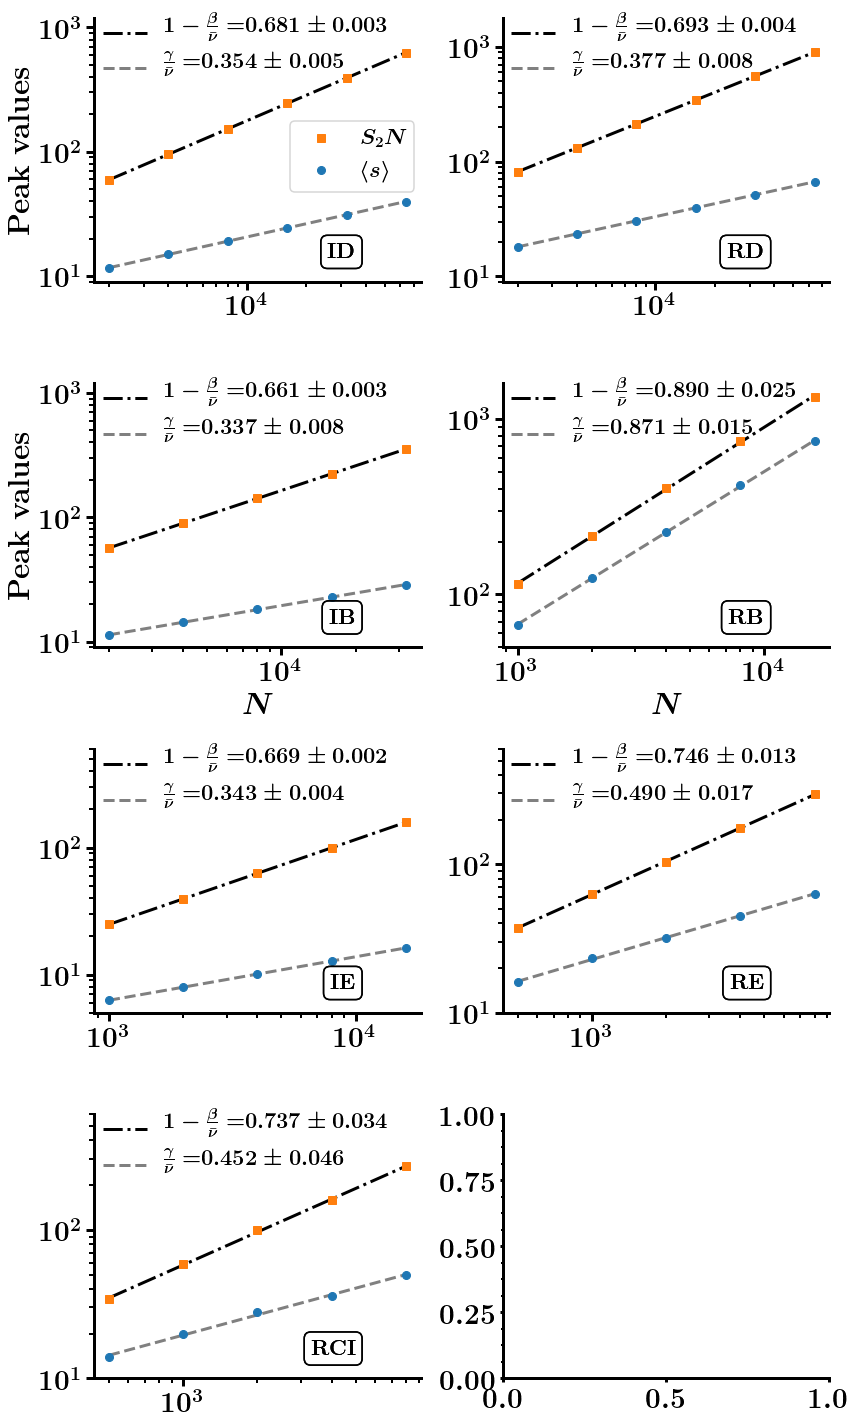

In [48]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
colors = mpl_settings_v3.colors

meank = 5
measures = ['Nsec', 'meanS']
attacks = ['Deg', 'DegU', 'Btw', 'BtwU', 'Eigenvector', 'EigenvectorU', 'CIU']
marker_dict = {'meanS': 'o', 'Nsec': 's'}
color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 N$'}

print('attack\t\tbeta/nu gamma/nu      1  delta_1     tau delta_tau')

ncols = 2
nrows = 4
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()

for k, attack in enumerate(attacks):
    ax = axes[k]
    
    if attack == 'Deg':
        N_values = [2000, 4000, 8000, 16000, 32000, 64000]
        ylim = (9, 1200)
    elif attack == 'DegU':
        N_values = [2000, 4000, 8000, 16000, 32000, 64000]
        ylim = (9, 1800)
    elif attack == 'Btw':
        N_values = [2000, 4000, 8000, 16000, 32000]
        ylim = (9, 1200)
    elif attack == 'BtwU':
        N_values = [1000, 2000, 4000, 8000, 16000]
        ylim = (50, 1600)
    elif attack == 'Eigenvector':
        N_values = [1000, 2000, 4000, 8000, 16000]
        ylim = (5, 600)
    elif attack == 'EigenvectorU':
        N_values = [500, 1000, 2000, 4000, 8000]
        ylim = (10, 600)
    elif attack == 'CIU':
        N_values = [500, 1000, 2000, 4000, 8000]
        ylim = (10, 600)
    ax.set_ylim(ylim)
            
    dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, meank)
    dfs = {}
    _N_values = N_values
    for N in _N_values:
        dfs[N] = dfsMax[N]
    N_values = list(dfs.keys())

    for i, measure in enumerate(measures):

        
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='major', length=8)
    
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
        if measure == 'Nsec':
            beta_over_nu = 1 - slope
            delta_beta = y_err
        elif measure == 'meanS':
            gamma_over_nu = slope
            delta_gamma = y_err

        if k in [0, 2]:
            ax.set_ylabel(r'$\mathrm{Peak\;values}$')
        if k in [2, 3]:
            ax.set_xlabel(r'$N$')

        if measure == 'meanS':
            label = r'$\frac{\gamma}{\bar{\nu}} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
            label1 = label
            line1, = ax.plot(N_values, Y_pred, '--', color='grey', label=label)
            
        elif measure == 'Nsec':
            #label = r'$\dfrac{\gamma}{\bar{\nu}} = {{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err)
            label = r'$1 - \frac{\beta}{\bar{\nu}} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
            label2 = label
            line2, = ax.plot(N_values, Y_pred, '-.', color='k', label=label)            

        ax.set_xscale('log')
        ax.set_yscale('log')
        if k == 0:
            markers1, = ax.plot(N_values, measure_values, marker_dict[measure], 
                                color=color_dict[measure], markersize=8, label=label_dict[measure])
        else:
            markers2, = ax.plot(N_values, measure_values, marker_dict[measure],
                                color=color_dict[measure], markersize=8)
        
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.8, 0.09, attack_dict[attack], fontsize=22, 
                transform=ax.transAxes, horizontalalignment='right', bbox=bbox)
    
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    print('{:10}\t{:.4f}    {:.4f} {:.4f}   {:.4f}  {:.4f}    {:.4f}'.format(attack, beta_over_nu, gamma_over_nu, 
                                                             2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau))
        
    if k == 0:
        handles, labels = ax.get_legend_handles_labels()
        order = [1, 3]
        legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  fontsize=22, loc=(0.6, 0.34))
        ax.add_artist(legend1)
        order = [0, 2]
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  fontsize=22, loc=(0.0, 0.73), frameon=False)

    else:
        ax.legend(fontsize=22, loc=(0.0, 0.73), frameon=False)

sns.despine()
plt.tight_layout()

plt.show()

attack	beta/nu gamma/nu      1  delta_1     tau delta_tau
Deg	0.3316    0.3483 1.0116   0.0076  2.4877    0.0088
DegU	0.3290    0.3592 1.0172   0.0122  2.4781    0.0142
Btw	0.4057    0.2822 1.0935   0.0601  2.5897    0.0774
BtwU	0.1891    0.7899 1.1682   0.4329  2.1932    0.8405


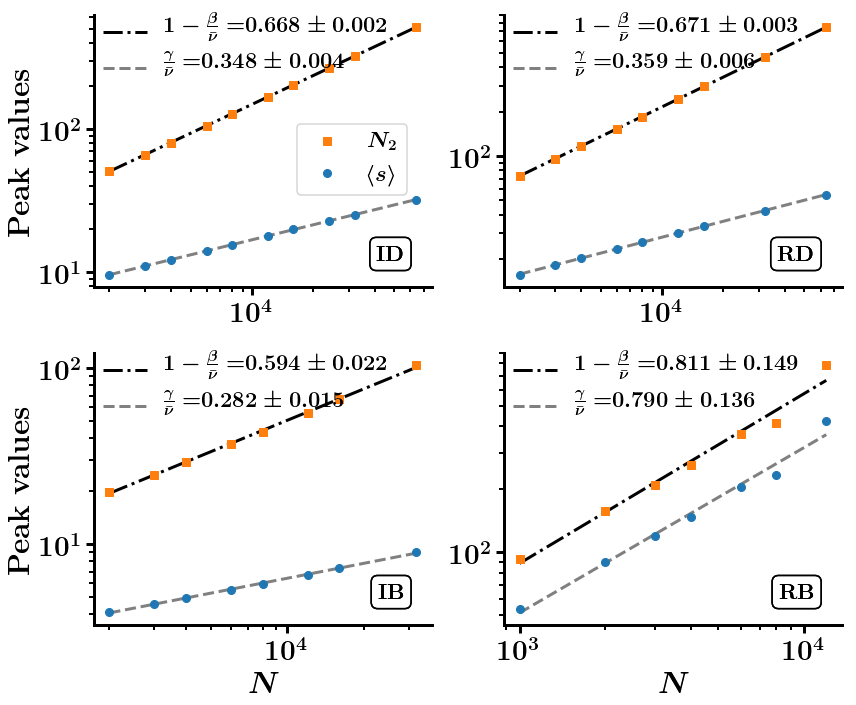

In [558]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
colors = mpl_settings_v3.colors

meank = 5
measures = ['Nsec', 'meanS']
attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
marker_dict = {'meanS': 'o', 'Nsec': 's'}
color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$N_2$'}

print('attack\tbeta/nu gamma/nu      1  delta_1     tau delta_tau')

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()

for k, attack in enumerate(attacks):
    ax = axes[k]
    
    if attack == 'Deg':
        #N_values = [8000, 12000, 16000, 32000, 64000]
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 24000, 32000, 64000]
        fmin = 0.44
        fmax = 0.49
        fc = 0.46524
        ylim = (9, 1200)
    elif attack == 'DegU':
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000]
        fmin = 0.334
        fmax = 0.345
        fc = 0.34014
        ylim = (9, 1800)
    elif attack == 'Btw':
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000]
        fmin = 0.5
        fmax = 0.6
        fc = 0.55761
        #fc = 0.552
        ylim = (9, 600)
    elif attack == 'BtwU':
        N_values = [1000, 2000, 3000, 4000, 6000, 8000, 12000]
        fmin = 0.28
        fmax = 0.32
        fc = 0.29806
        ylim = (50, 1600)
        
    #ax.set_ylim(ylim)
            
    dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, meank)
    dfs = {}
    _N_values = N_values
    for N in _N_values:
        dfs[N] = dfsMax[N]
    N_values = list(dfs.keys())

    for i, measure in enumerate(measures):

        
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='major', length=8)
    
        #mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False)
        measure_values = get_critical_measures(dfs, measure, fc=fc)
        Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
        if measure == 'Nsec':
            beta_over_nu = 1 - slope
            delta_beta = y_err
        elif measure == 'meanS':
            gamma_over_nu = slope
            delta_gamma = y_err

        if k in [0, 2]:
            #ax.set_ylabel(r'$N_2\; \mathrm{ and }\; \langle s \rangle$')
            ax.set_ylabel(r'$\mathrm{Peak\;values}$')
        if k in [2, 3]:
            ax.set_xlabel(r'$N$')

        if measure == 'meanS':
            label = r'$\frac{\gamma}{\bar{\nu}} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
            label1 = label
            line1, = ax.plot(N_values, Y_pred, '--', color='grey', label=label)
            
        elif measure == 'Nsec':
            #label = r'$\dfrac{\gamma}{\bar{\nu}} = {{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err)
            label = r'$1 - \frac{\beta}{\bar{\nu}} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
            label2 = label
            line2, = ax.plot(N_values, Y_pred, '-.', color='k', label=label)            

        ax.set_xscale('log')
        ax.set_yscale('log')
        if k == 0:
            markers1, = ax.plot(N_values, measure_values, marker_dict[measure], 
                                color=color_dict[measure], markersize=8, label=label_dict[measure])
        else:
            markers2, = ax.plot(N_values, measure_values, marker_dict[measure],
                                color=color_dict[measure], markersize=8)
        
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.92, 0.1, attack_dict[attack], fontsize=22, 
                transform=ax.transAxes, horizontalalignment='right', bbox=bbox)
    
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    print('{}\t{:.4f}    {:.4f} {:.4f}   {:.4f}  {:.4f}    {:.4f}'.format(attack, beta_over_nu, gamma_over_nu, 
                                                             2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau))
        
    if k == 0:
        handles, labels = ax.get_legend_handles_labels()
        order = [1, 3]
        legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  fontsize=22, loc=(0.6, 0.34))
        ax.add_artist(legend1)
        order = [0, 2]
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  fontsize=22, loc=(0.0, 0.73), frameon=False)

    else:
        ax.legend(fontsize=22, loc=(0.0, 0.73), frameon=False)

sns.despine()
plt.tight_layout()

fig_name = os.path.join(fig_dir, 'measures_fc')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

Deg
[ 32.11027074  37.14401878  41.61538771  48.94409606  53.75749865
  62.54225902  69.61979857  89.30596051 114.99049818]
Deg	0.368 +- 0.006
	2.715 +- 0.045
DegU
[ 66.50431346  78.76102656  88.38884652 103.44826295 116.28293261
 135.4553568  152.4485059  197.03136621 253.81697625]
DegU	0.386 +- 0.009
	2.588 +- 0.061
Btw
[32.4965605  37.78933049 42.02290675 49.02406848 54.08820321 62.42409657
 69.10252172 85.32295129]
Btw	0.351 +- 0.017
	2.846 +- 0.137
BtwU
[131.32726333 173.09553531 211.82265909 331.71098443]
BtwU	0.668 +- 0.025
	1.496 +- 0.057


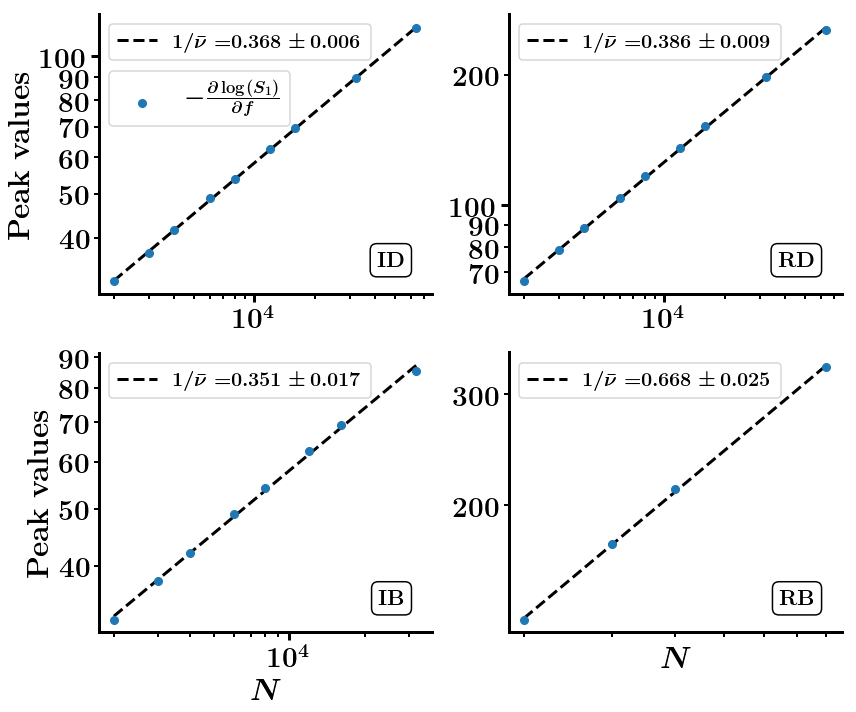

In [364]:
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

meank = 5
attacks = ['Deg', 'DegU', 'Btw', 'BtwU']

fminmax_values = {
    'Ran': (0.72, 0.87), 
    'Deg': (0.4, 0.55), 
    'DegU': (0.315, 0.38),
    'Btw': (0.4, 0.65), 
    'BtwU': (0.26, 0.32)
}

args = dict(itern=200, alph=5e-4, ep=1e-2, scale='large', plotflag=0, diagflag=0) 

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()

for k, attack in enumerate(attacks):
    print(attack)
    if attack == 'Deg':
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000]
        #N_values = [2000, 3000, 4000, 6000, 8000, 12000]
    elif attack == 'DegU':
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000]
    elif attack == 'Btw':
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000]
    elif attack == 'BtwU':
        N_values = [2000, 3000, 4000, 8000]
     

    net_dir_name = '../networks/ER/ER_k5.00'
    fmin, fmax = fminmax_values[attack]
    max_values = []
    for N in N_values:
    
        network = 'ER_k{:.2f}_N{:d}'.format(meank, N)
        base_file_name = 'TVRegDiff_itern{}_alph{}_ep{}_{}_fmin{:.4f}_fmax{:.4f}.txt'.format(args['itern'], args['alph'], 
                                                                                             args['ep'], 
                                                                                             attack, fmin, fmax)
        data_file = os.path.join(net_dir_name, network, base_file_name)

        f, deriv, deriv_np = np.loadtxt(data_file)
        max_pos = np.argmin(deriv)
        max_value = -np.min(deriv)
        max_values.append(max_value)

    max_values = np.array(max_values)

    
    ax = axes[k]
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)

    Y_pred, slope, y_err = getLinearReg(N_values, max_values)

    if k in [0, 2]:
        ax.set_ylabel(r'$\mathrm{Peak\;values}$')
        #ax.set_ylabel(r'$\mathrm{max}\left[ -d \log(S_1)/df \right]$')
    if k in [2, 3]:
        ax.set_xlabel(r'$N$')

    label = r'$1/\bar{\nu} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
    ax.plot(N_values, Y_pred, '--', color='black', label=label)
    if k == 0:
        ax.plot(N_values, max_values, 'o', markersize=8, label=r'$- \frac{\partial \log(S_1)}{\partial f}$')
    else:
        ax.plot(N_values, max_values, 'o', markersize=8)
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    print(max_values)
    ax.set_xticklabels([], minor=True)
    ax.yaxis.set_major_formatter(FormatStrFormatter(r'$%d$'))
    ax.yaxis.set_minor_formatter(FormatStrFormatter(r'$%d$'))
    
    bbox = {'boxstyle': 'round', 'fc': 'None'}
    ax.text(0.92, 0.1, attack_dict[attack], fontsize=22, 
            transform=ax.transAxes, horizontalalignment='right', bbox=bbox)
    
    if k == 0:
        handles, labels = ax.get_legend_handles_labels()
        legend1 = ax.legend([handles[1]], [labels[1]], loc=(0.03, 0.6), fontsize=24)
        ax.add_artist(legend1)
        ax.legend([handles[0]], [labels[0]], loc=2, fontsize=20)
    else:
        ax.legend(loc=2, fontsize=20)
    
    inverse_err = (1/slope**2) * (y_err)
    print('{}\t{:.3f} +- {:.3f}'.format(attack, slope, y_err))
    print('\t{:.3f} +- {:.3f}'.format(1/slope, inverse_err))

sns.despine()
plt.tight_layout()

fig_name = os.path.join(fig_dir, 'peaks_deriv')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

BtwU
BtwU
BtwU


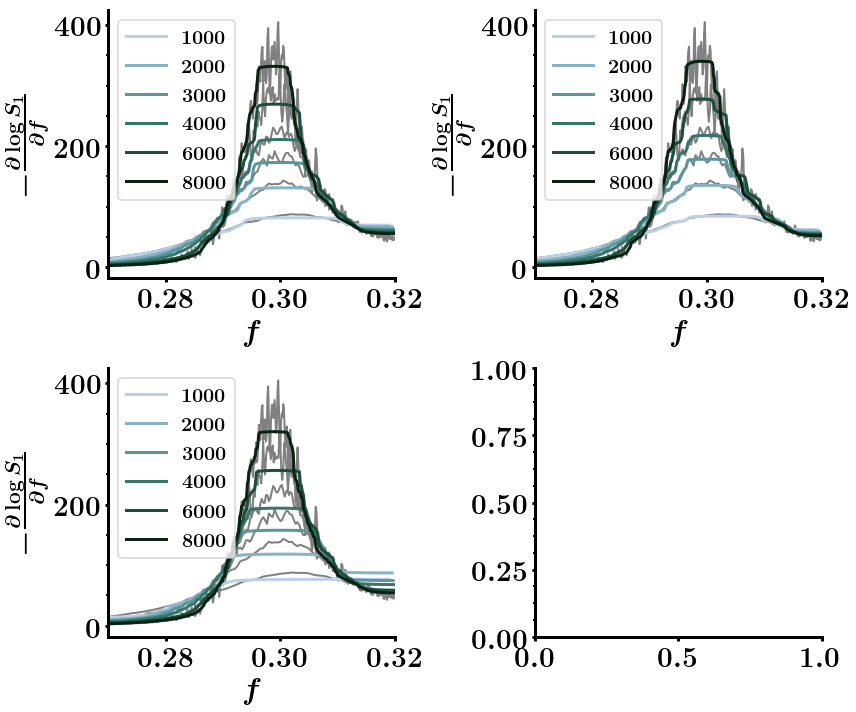

In [488]:
meank = 5
attacks = ['Deg', 'DegU', 'Btw', 'BtwU']

fminmax_values = {
    'Ran': (0.72, 0.87), 
    'Deg': (0.4, 0.55), 
    'DegU': (0.315, 0.38),
    'Btw': (0.4, 0.65), 
    'BtwU': (0.26, 0.32)
}

#args = dict(itern=200, alph=5e-4, ep=1e-2, scale='large', plotflag=0, diagflag=0) 

args_list = [
    #dict(itern=200, alph=5e-4, ep=1e-3, scale='large', plotflag=0, diagflag=0),
    dict(itern=200, alph=5e-4, ep=1e-2, scale='large', plotflag=0, diagflag=0),
    #dict(itern=200, alph=5e-4, ep=1e-1, scale='large', plotflag=0, diagflag=0),
    dict(itern=200, alph=1e-4, ep=1e-2, scale='large', plotflag=0, diagflag=0),
    dict(itern=200, alph=5e-3, ep=1e-2, scale='large', plotflag=0, diagflag=0),
    dict(itern=200, alph=1e-4, ep=1e-1, scale='large', plotflag=0, diagflag=0)
]

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()

#for k, attack in enumerate(attacks[-1:]):
attack = 'BtwU'
for k, args in enumerate(args_list):
    print(attack)
    
    ax = axes[k]
 
    if attack == 'Deg':
        N_values = [4000, 8000, 16000, 32000, 64000]
        xlim = (0.42, 0.57)
    elif attack == 'DegU':
        N_values = [4000, 8000, 16000, 32000, 64000]
        xlim = (0.32, 0.38)
    elif attack == 'Btw':
        N_values = [4000, 8000, 16000, 32000]
        xlim = (0.38, 0.62)
    elif attack == 'BtwU':
        N_values = [1000, 2000, 3000, 4000, 6000, 8000]
        xlim = (0.27, 0.32)  
    
    colors = sns.cubehelix_palette(len(N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
    
    ax.set_xlim(xlim)
    
    net_dir_name = '../networks/ER/ER_k5.00'
    fmin, fmax = fminmax_values[attack]

    deriv_values = []
    for i, N in enumerate(N_values):
    
        network = 'ER_k{:.2f}_N{:d}'.format(meank, N)
        base_file_name = 'TVRegDiff_itern{}_alph{}_ep{}_{}_fmin{:.4f}_fmax{:.4f}.txt'.format(args['itern'], args['alph'], 
                                                                                             args['ep'], 
                                                                                             attack, fmin, fmax)
        data_file = os.path.join(net_dir_name, network, base_file_name)

        f, deriv, deriv_np = np.loadtxt(data_file)
        deriv_values.append([N, f, deriv])
        ax.plot(f, -deriv_np, color='grey', linewidth=2)
        
    for i, (N, f, deriv) in enumerate(deriv_values):    
        ax.plot(f, -deriv, label=r'${{{}}}$'.format(N), color=colors[i])
        
    ax.set_xlabel(r'$f$')
    ax.set_ylabel(r'$-\frac{\partial \log S_1}{\partial f}$')
    ax.legend(loc='best', fontsize=20)

    
sns.despine()
plt.tight_layout()

fig_name = os.path.join(fig_dir, 'derivs')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

Deg
DegU
Btw
BtwU
Deg
Deg	0.368 +- 0.006
	2.715 +- 0.045
DegU
DegU	0.386 +- 0.009
	2.588 +- 0.059
Btw
Btw	0.351 +- 0.017
	2.845 +- 0.139
BtwU
BtwU	0.666 +- 0.021
	1.501 +- 0.046


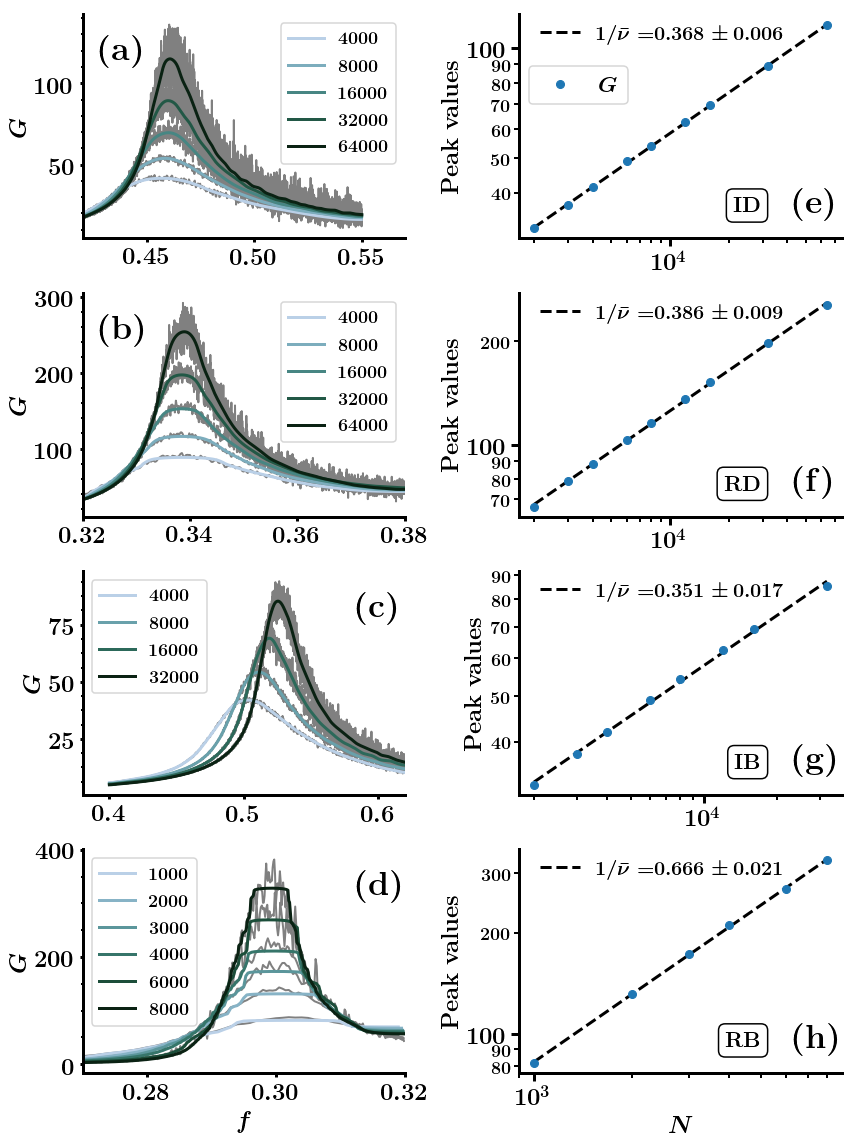

In [130]:
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

meank = 5
attacks = ['Deg', 'DegU', 'Btw', 'BtwU']

fminmax_values = {
    'Ran': (0.72, 0.87), 
    'Deg': (0.4, 0.55), 
    'DegU': (0.315, 0.38),
    'Btw': (0.4, 0.65), 
    'BtwU': (0.26, 0.32)
}

args = dict(itern=200, alph=5e-4, ep=1e-2, scale='large', plotflag=0, diagflag=0) 

ncols = 2
nrows = 4
fig, axes = plt.subplots(figsize=(6*ncols, 4*nrows), ncols=ncols, nrows=nrows)

for k, attack in enumerate(attacks):
    print(attack)
    
    ax = axes[k,0]
 
    if attack == 'Deg':
        N_values = [4000, 8000, 16000, 32000, 64000]
        xlim = (0.42, 0.57)
    elif attack == 'DegU':
        N_values = [4000, 8000, 16000, 32000, 64000]
        xlim = (0.32, 0.38)
    elif attack == 'Btw':
        N_values = [4000, 8000, 16000, 32000]
        xlim = (0.38, 0.62)
    elif attack == 'BtwU':
        N_values = [1000, 2000, 3000, 4000, 6000, 8000]
        xlim = (0.27, 0.32)  
    
    colors = sns.cubehelix_palette(len(N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
    
    ax.set_xlim(xlim)
    
    net_dir_name = '../networks/ER/ER_k5.00'
    fmin, fmax = fminmax_values[attack]

    deriv_values = []
    for i, N in enumerate(N_values):
    
        network = 'ER_k{:.2f}_N{:d}'.format(meank, N)
        base_file_name = 'TVRegDiff_itern{}_alph{}_ep{}_{}_fmin{:.4f}_fmax{:.4f}.txt'.format(args['itern'], args['alph'], 
                                                                                             args['ep'], 
                                                                                             attack, fmin, fmax)
        data_file = os.path.join(net_dir_name, network, base_file_name)

        f, deriv, deriv_np = np.loadtxt(data_file)
        deriv_values.append([N, f, deriv])
        ax.plot(f, -deriv_np, color='grey', linewidth=2)
        
    for i, (N, f, deriv) in enumerate(deriv_values):    
        ax.plot(f, -deriv, label=r'${{{}}}$'.format(N), color=colors[i])
        
    if k == 3:
        ax.set_xlabel(r'$f$', fontsize=24)
    #ax.set_ylabel(r'$-\frac{\partial \log S_1}{\partial f}$', fontsize=32)
    ax.set_ylabel(r'$G$', fontsize=24)
    ax.legend(loc='best', fontsize=18)
    
    if k < 2:
        ax.text(0.05, 0.8, letters[k], fontsize=34, transform=ax.transAxes, 
                horizontalalignment='left')
    else:
        ax.text(0.85, 0.8, letters[k], fontsize=34, transform=ax.transAxes, 
                horizontalalignment='left')
    
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=18)

for k, attack in enumerate(attacks):
    print(attack)
    if attack == 'Deg':
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000]
    elif attack == 'DegU':
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000]
    elif attack == 'Btw':
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000]
    elif attack == 'BtwU':
        N_values = [1000, 2000, 3000, 4000, 6000, 8000]
     

    net_dir_name = '../networks/ER/ER_k5.00'
    fmin, fmax = fminmax_values[attack]
    max_values = []
    for N in N_values:
    
        network = 'ER_k{:.2f}_N{:d}'.format(meank, N)
        base_file_name = 'TVRegDiff_itern{}_alph{}_ep{}_{}_fmin{:.4f}_fmax{:.4f}.txt'.format(args['itern'], args['alph'], 
                                                                                             args['ep'], 
                                                                                             attack, fmin, fmax)
        data_file = os.path.join(net_dir_name, network, base_file_name)

        f, deriv, deriv_np = np.loadtxt(data_file)
        max_pos = np.argmin(deriv)
        max_value = -np.min(deriv)
        max_values.append(max_value)

    max_values = np.array(max_values)

    
    ax = axes[k,1]
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)

    Y_pred, slope, y_err = getLinearReg(N_values, max_values)


    ax.set_ylabel(r'$\mathrm{Peak\;values}$', fontsize=24)
    if k == 3:
        ax.set_xlabel(r'$N$', fontsize=24)

    label = r'$1/\bar{\nu} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
    ax.plot(N_values, Y_pred, '--', color='black', label=label)
    if k == 0:
        #ax.plot(N_values, max_values, 'o', markersize=8, label=r'$- \frac{\partial \log(S_1)}{\partial f}$')
        ax.plot(N_values, max_values, 'o', markersize=8, label=r'$G$')
    else:
        ax.plot(N_values, max_values, 'o', markersize=8)
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    #print(max_values)
    ax.set_xticklabels([], minor=True)
    ax.yaxis.set_major_formatter(FormatStrFormatter(r'$%d$'))
    ax.yaxis.set_minor_formatter(FormatStrFormatter(r'$%d$'))
    
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    
    bbox = {'boxstyle': 'round', 'fc': 'None'}
    #ax.text(0.92, 0.1, attack_dict[attack], fontsize=22, 
    #ax.text(0.05, 0.65, attack_dict[attack], fontsize=22, 
    #        transform=ax.transAxes, horizontalalignment='left', bbox=bbox)
    
    ax.text(0.75, 0.12, attack_dict[attack], fontsize=22, transform=ax.transAxes, 
                horizontalalignment='right', bbox=bbox)
    
    ax.text(0.85, 0.12, letters[k+4], fontsize=34, transform=ax.transAxes, 
                horizontalalignment='left')
    
    if k == 0:
        handles, labels = ax.get_legend_handles_labels()
        legend1 = ax.legend([handles[1]], [labels[1]], 
                            loc=(0.03, 0.6), 
                            #loc=(0.7, 0.08), 
                            fontsize=22)
        ax.add_artist(legend1)
        ax.legend([handles[0]], [labels[0]], fontsize=20, loc=(0.04, 0.83), frameon=False)
    else:
        ax.legend(fontsize=20, loc=(0.04, 0.83), frameon=False)
    
    inverse_err = (1/slope**2) * (y_err)
    print('{}\t{:.3f} +- {:.3f}'.format(attack, slope, y_err))
    print('\t{:.3f} +- {:.3f}'.format(1/slope, inverse_err))

    
sns.despine()
plt.tight_layout()

fig_name = os.path.join(fig_dir, 'derivs_with_peaks')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

Deg	0.4653 2.80 0.08
DegU	0.3401 3.38 0.21
Btw	0.5573 3.52 0.16
BtwU	0.2974 2.66 0.23


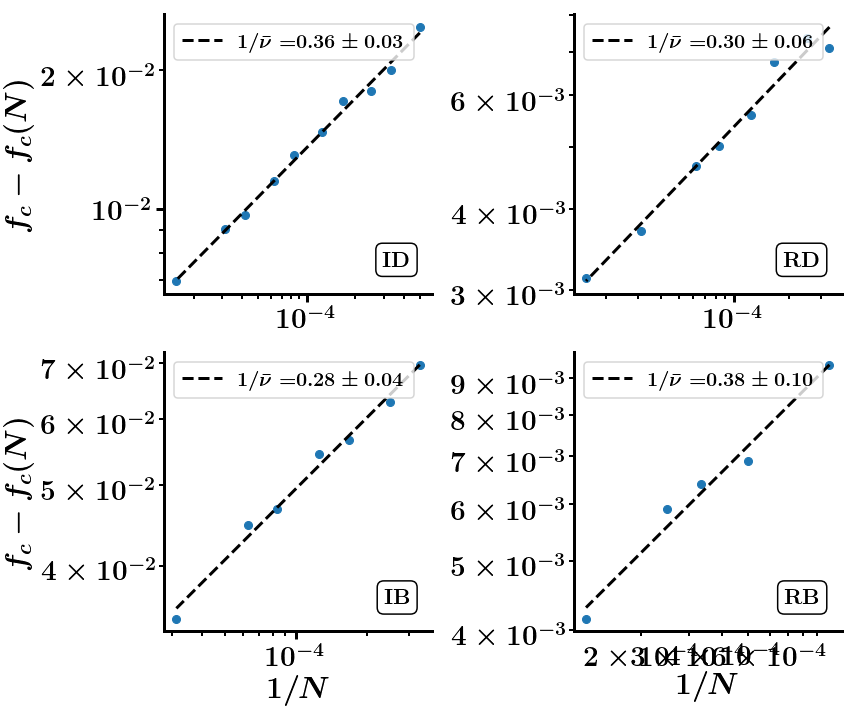

Deg	0.4653 3.19 0.12
DegU	0.3401 3.51 0.24
Btw	0.5573 3.55 0.12
BtwU	0.2974 3.06 0.38


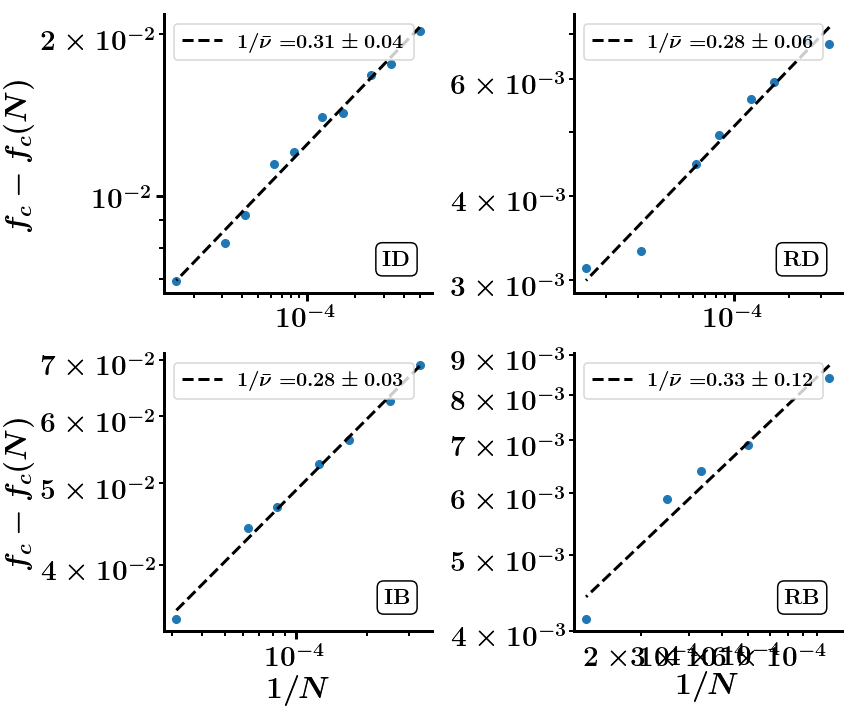

In [301]:
def plot_nu(measure):

    attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
    marker_dict = {'meanS': 'o', 'Nsec': 's'}
    color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
    linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
    label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$N_2$'}

    ncols = 2
    nrows = 2
    fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    for k, attack in enumerate(attacks):

        if attack == 'Deg':
            #N_values = [8000, 12000, 16000, 32000, 64000]
            N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 24000, 32000, 64000]
            fc_theo = 0.4653
            fmin = 0.44
            fmax = 0.49
        elif attack == 'DegU':
            N_values = [3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000]
            fc_theo = 0.3401
            fmin = 0.334
            fmax = 0.345
        elif attack == 'Btw':
            N_values = [3000, 4000, 6000, 8000, 12000, 16000, 32000]
            fc_theo = 0.5573
            tolerance = fc_theo/500
            fmin = 0.5
            fmax = 0.6
        elif attack == 'BtwU':
            N_values = [1000, 2000, 3000, 4000, 8000]
            fc_theo = 0.2974
            tolerance = fc_theo/500
            fmin = 0.28
            fmax = 0.32

        dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, meank)
        dfs = {}
        _N_values = N_values
        for N in _N_values:
            dfs[N] = dfsMax[N]
        N_values = list(dfs.keys())
        
        #fc = compute_fc_v2(dfs, fmin, fmax)[0]
        #if attack == 'Deg' or attack == 'Btw':
        #    fc = fc_theo
        fc = fc_theo
                
        ax = axes[k]
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='major', length=8)
        
        
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
        if measure == 'Nsec':
            beta_over_nu = 1 - slope
        elif measure == 'meanS':
            gamma_over_nu = slope

        if k in [0, 2]:
            #ax.set_ylabel(r'$N_2\; \mathrm{ and }\; \langle s \rangle$')
            ax.set_ylabel(r'$f_c - f_c(N)$')
        if k in [2, 3]:
            ax.set_xlabel(r'$1/N$')


        ax.set_xscale('log')
        ax.set_yscale('log')

        fc_values, peak_values = getPeaks(dfs, measure)
        fc_diff = fc - np.array(fc_values)
        one_over_N_values = 1/np.array(N_values)
        ax.plot(one_over_N_values, fc_diff, 'o', markersize=8)
        Y_pred, slope, y_err = getLinearReg(one_over_N_values, fc_diff)

        label = r'$1/\bar{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        ax.plot(one_over_N_values, Y_pred, '--', color='k', label=label)

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.92, 0.1, attack_dict[attack], fontsize=22, 
                transform=ax.transAxes, horizontalalignment='right', bbox=bbox)

        ax.legend(fontsize=20, loc=2)
        
        #fc_16k = dict(zip(N_values, fc_values))[16000]
        #print('{}\t{:.4f} {:.2f} {:.2f} fc(16000) = {:.4f}'.format(attack, fc, 1/slope, y_err/(3*slope**2), fc_16k))
        print('{}\t{:.4f} {:.2f} {:.2f}'.format(attack, fc, 1/slope, y_err/(3*slope**2)))
        
        ax.set_xticks([1e-4])
        
    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'nu_' + measure)
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')

    plt.show()
    
measures = ['meanS', 'Nsec']
for measure in measures:
    plot_nu(measure)

Deg [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 24000, 32000, 64000] [0.437, 0.4405, 0.44533333333333336, 0.44725, 0.44816666666666666, 0.450875, 0.45225, 0.4538125, 0.455625, 0.45628125, 0.45834375]
DegU [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000, 128000] [0.33, 0.332, 0.333, 0.33275, 0.3333333333333333, 0.3345, 0.33508333333333334, 0.3355625, 0.33640625, 0.33696875, 0.337671875]
Btw [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000] [0.463, 0.481, 0.4876666666666667, 0.4945, 0.5006666666666667, 0.50475, 0.5105, 0.5130625, 0.52275, 0.52934375]
BtwU [1000, 2000, 3000, 4000, 6000, 16000] [0.288, 0.2905, 0.291, 0.2915, 0.293, 0.2955625]


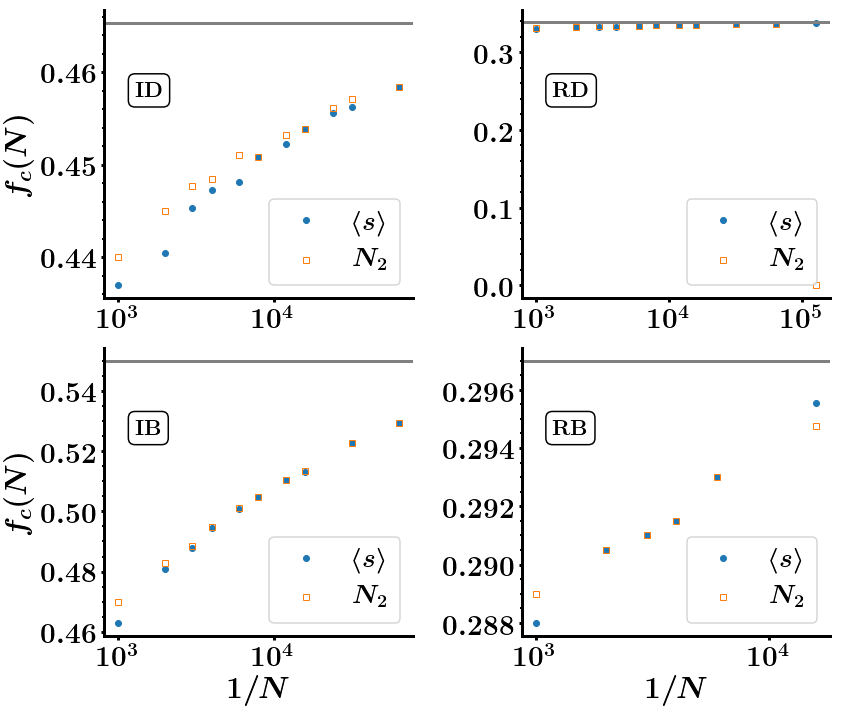

In [138]:
def plot_fc_N():
    from mpl_settings_v3 import colors

    attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
    marker_dict = {'meanS': 'o', 'Nsec': 's'}
    color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
    linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
    label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$N_2$'}

    ncols = 2
    nrows = 2
    fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    for k, attack in enumerate(attacks):

        if attack == 'Deg':
            N_values = [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 24000, 32000, 64000]
            fc_theo = 0.4653
            fmin = 0.44
            fmax = 0.49
        elif attack == 'DegU':
            N_values = [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000, 128000]
            fc_theo = 0.3395
            fmin = 0.334
            fmax = 0.345
        elif attack == 'Btw':
            N_values = [1000, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000]
            fc_theo = 0.55
            tolerance = fc_theo/500
            fmin = 0.5
            fmax = 0.6
        elif attack == 'BtwU':
            N_values = [1000, 2000, 3000, 4000, 6000, 16000]
            fc_theo = 0.297
            tolerance = fc_theo/500
            fmin = 0.28
            fmax = 0.32

        dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, meank)
        dfs = {}
        _N_values = N_values
        for N in _N_values:
            dfs[N] = dfsMax[N]
        N_values = list(dfs.keys())
        
        measures = ['meanS', 'Nsec']
        fc = fc_theo
                
        ax = axes[k]
        if k in [0, 2]:
            ax.set_ylabel(r'$f_c(N)$')
        if k in [2, 3]:
            ax.set_xlabel(r'$1/N$')

        ax.set_xscale('log')
        
        one_over_N_values = 1/np.array(N_values)
        measures = ['meanS', 'Nsec']
        for measure in measures:
            fc_values, peak_values = getPeaks(dfs, measure)
            if measure == 'meanS':
                print(attack, N_values, fc_values)
        
            if measure == 'meanS':
                ax.plot(N_values, fc_values, 'o',  markersize=6, color=colors[0], label=r'$\langle s \rangle$')
            else:
                ax.plot(N_values, fc_values, 's', fillstyle='none', markersize=6, color=colors[1], label=r'$N_2$')
        ax.axhline(fc, color='grey')

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.1, 0.7, attack_dict[attack], fontsize=22, 
                transform=ax.transAxes, horizontalalignment='left', bbox=bbox)      
    
        ax.legend(loc=4)
    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'fc_N')
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')

    plt.show()
    
plot_fc_N()

Deg 0.4653 0.32 2.7
DegU 0.3395 0.305 2.6
Btw 0.55 0.33333 3.0
BtwU 0.29685 0.1 1.5


/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


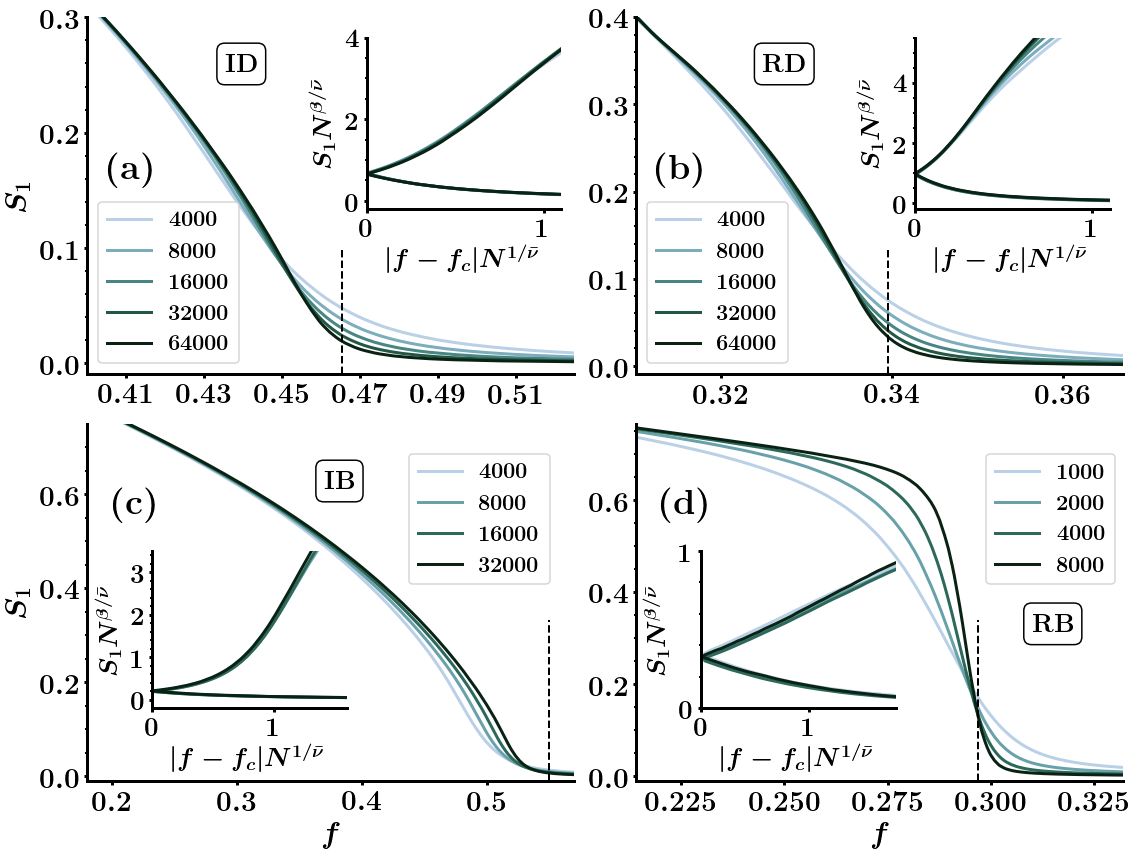

In [165]:
def plot_S1_scaling(fc_values, beta_over_nu_values, nu_values):

    ncols = 2
    nrows = 2
    fig, axes = plt.subplots(figsize=(8*ncols, 6*ncols), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
    for j, attack in enumerate(attacks):
        
        ax = axes[j]

        if attack == 'Deg':
            N_values = [4000, 8000, 16000, 32000, 64000]
            fc = 0.4653
            beta_over_nu = 0.32
            nu = 2.7
            fmin = 0.4
            fmax = 0.525
            ymin = -0.01
            ymax = 0.3   
            bbox_to_anchor = (.6, .5, .4, .48)
            box_place = (0.35, 0.85)
            box2_place = (0.04, 0.55)
            ax.set_xticks([0.41, 0.43, 0.45, 0.47, 0.49, 0.51])

        if attack == 'DegU':
            N_values = [4000, 8000, 16000, 32000, 64000]
            fc = 0.3395
            beta_over_nu = 0.305
            nu = 2.3
            fmin = 0.31
            #fmax = 0.377
            fmax = 0.367
            ymin = -0.01
            ymax = 0.4
            bbox_to_anchor = (.6, .5, .4, .48)
            box_place = (0.35, 0.85)
            box2_place = (0.04, 0.55)
            
        if attack == 'Btw':
            N_values = [4000, 8000, 16000, 32000]
            fc = 0.55
            beta_over_nu = 0.333
            nu = 3.0
            fmin = 0.18
            fmax = 0.57
            ymin = -0.01
            ymax = 0.75
            bbox_to_anchor = (.16, .24, .4, .44)
            #box_place = (0.55, 0.88)
            box2_place = (0.05, 0.75)
            box_place = (0.55, 0.82)
            
        if attack == 'BtwU':
            N_values = [1000, 2000, 4000, 8000]
            fc = 0.2974
            #beta_over_nu = 0.12
            beta_over_nu = 0.095 
            nu = 1.5
            fmin = 0.214
            fmax = 0.332
            ymin = -0.01
            ymax = 0.765
            bbox_to_anchor = (.16, .24, .4, .44)
            #box_place = (0.87, 0.4)
            box2_place = (0.05, 0.75)
            box_place = (0.9, 0.42)

        meank = 5
        _, _, _, dfs = load_dfs(attack, N_values, meank)
        
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(fmin, fmax)
        
        if j in [0, 2]:
            ax.set_ylabel(r'$S_1$')
        if j in [2, 3]:
            ax.set_xlabel(r'$f$')

        _N_values = list(dfs.keys())
        colors = sns.cubehelix_palette(len(_N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
        for i, N in enumerate(_N_values):
            df = dfs[N]
            ax.plot(df.f, df.Sgcc, '-', label=r'${{{}}}$'.format(N), color=colors[i])
            
        if fc_values:
            fc = fc_values[attack]
        if beta_over_nu_values:
            beta_over_nu = beta_over_nu_values[attack]
        if nu_values:
            nu = nu_values[attack]
        print(attack, fc, beta_over_nu, nu)   
    
        

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(*box_place, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='right')
        
        ax.text(*box2_place, letters[j], fontsize=36, transform=ax.transAxes, 
                horizontalalignment='left')
        
        axins = inset_axes(ax, width="100%", height="100%",
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=ax.transAxes)
        axins.patch.set_alpha(0.)
        axins.tick_params(labelsize=26)
        axins.set_xlim(0, 1.1)
        if attack == 'Deg':
            axins.set_ylim(-0.2, 4)
            ax.legend(fontsize=22, loc='lower left')
            dashed_max = 0.35
        elif attack == 'DegU':
            axins.set_ylim(-0.2, 5.5)
            axins.set_yticks([0, 2, 4])
            ax.legend(fontsize=22, loc='lower left')
            dashed_max = 0.35
        elif attack == 'Btw':
            axins.set_xlim(0, 1.6)
            axins.set_ylim(-0.2, 3.5)
            axins.set_yticks([0, 1, 2, 3])
            ax.legend(fontsize=22, loc=(0.66, 0.55))
            dashed_max = 0.45
        elif attack == 'BtwU':
            axins.set_xlim(0, 1.8)
            axins.set_ylim(0, 1)
            axins.set_yticks([0, 1])
            #ax.legend(fontsize=22, loc='upper right')
            ax.legend(fontsize=22, loc=(0.72, 0.55))
            dashed_max = 0.45
            
        ax.axvline(fc, 0, dashed_max, linestyle='--', color='k', linewidth=2)

        axins.set_xlabel(r'$|f-f_c| N^{1/\bar{\nu}}$', fontsize=26)
        axins.set_ylabel(r'$S_1 N^{\beta/\bar{\nu}}$', fontsize=26)
        for i, N in enumerate(_N_values):  
                
            df = dfs[N]
            X = np.fabs(fc - df.f)*N**(1/nu)
            Y = df.Sgcc*N**(beta_over_nu)
            axins.plot(X, Y, '-', color=colors[i])
        

    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'S1_scaling')
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    
    plt.show()
    
fc_values = {
    'Deg':  0.4653,
    'DegU': 0.3395,
    'Btw':  0.55,
    #'BtwU': 0.2965
    'BtwU': 0.29685
}
    
    
beta_over_nu_values = {
    'Deg':  0.32,
    'DegU': 0.305,
    'Btw':  0.33333,
    #'BtwU': 0.095  
    'BtwU': 0.1
}

nu_values =  {
    'Deg':  2.7,
    'DegU': 2.6,
    'Btw':  3.0,
    'BtwU': 1.5    
}

plot_S1_scaling(fc_values, beta_over_nu_values, nu_values)

Deg 0.4653 0.32 3.0
DegU 0.3395 0.307 2.6
Btw 0.55 0.33333 3.0
BtwU 0.2954 0.094 1.5


/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


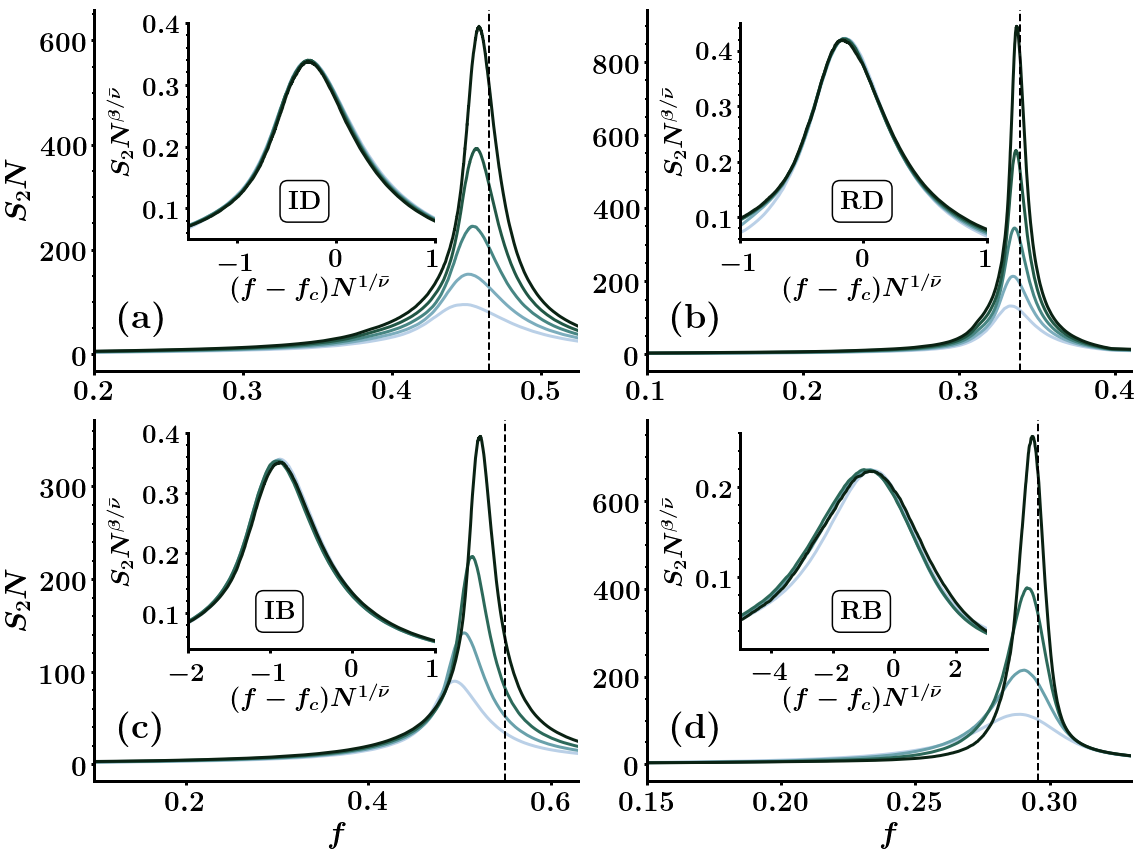

In [158]:
def plot_N2_scaling(fc_values, beta_over_nu_values, nu_values):

    ncols = 2
    nrows = 2
    fig, axes = plt.subplots(figsize=(8*ncols, 6*ncols), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
    for j, attack in enumerate(attacks):
        
        if attack == 'Deg':
            N_values = [4000, 8000, 16000, 32000, 64000]
            fc = 0.4653
            fmin = 0.44
            fmax = 0.49
            beta_over_nu = 0.32
            nu = 2.7
        elif attack == 'DegU':
            N_values = [4000, 8000, 16000, 32000, 64000]
            fc = 0.3395
            fmin = 0.334
            fmax = 0.345
            beta_over_nu = 0.305
            nu = 2.3
        elif attack == 'Btw':
            N_values = [4000, 8000, 16000, 32000]
            fc = 0.55
            fmin = 0.5
            fmax = 0.6
            beta_over_nu = 0.333
            nu = 3.0
        elif attack == 'BtwU':
            N_values = [1000, 2000, 4000, 8000]
            fc = 0.2965
            fmin = 0.28
            fmax = 0.32
            #beta_over_nu = 0.12
            beta_over_nu = 0.095 
            nu = 1.5

        meank = 5
        _, _, _, dfs = load_dfs(attack, N_values, meank)
        
        ax = axes[j]

        if attack == 'Deg':
            fmin = 0.2
            fmax = 0.525
            ymin = 0
            ymax = 0.55   
            bbox_to_anchor = (.6, .5, .4, .48)
            box_place = (0.4, 0.45)   

        if attack == 'DegU':
            fmin = 0.1
            fmax = 0.41
            ymin = 0
            ymax = 0.4
            bbox_to_anchor = (.6, .5, .4, .48)
            box_place = (0.4, 0.45)   
            
        if attack == 'Btw':
            fmin = 0.1
            fmax = 0.63
            ymin = 0
            ymax = 0.7
            bbox_to_anchor = (.16, .24, .4, .44)
            box_place = (0.35, 0.45)   
            
        if attack == 'BtwU':
            fmin = 0.15
            fmax = 0.33
            ymin = 0
            ymax = 0.765
            bbox_to_anchor = (.16, .24, .4, .44)
            box_place = (0.4, 0.45)   
                      
        #ax.set_ylim(ymin, ymax)
        ax.set_xlim(fmin, fmax)
        
        if j in [0, 2]:
            #ax.set_ylabel(r'$N_2$')
            ax.set_ylabel(r'$S_2N$')
        if j in [2, 3]:
            ax.set_xlabel(r'$f$')

        _N_values = list(dfs.keys())
        colors = sns.cubehelix_palette(len(_N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
        
        for i, N in enumerate(_N_values):
            df = dfs[N]
            ax.plot(df.f, df.Nsec, '-', color=colors[i])
        
        
        bbox_to_anchor = (.22, .4, .51, .6)
        axins = inset_axes(ax, width="100%", height="100%",
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=ax.transAxes)
        axins.patch.set_alpha(0.)
        
        axins.tick_params(labelsize=26)
        if attack == 'Deg':
            pass
            axins.set_xlim(-1.5, 1)
            axins.set_ylim(0.05, 0.4)
        elif attack == 'DegU':
            axins.set_xlim(-1., 1.)
            axins.set_ylim(0.06, 0.45)
            axins.set_yticks([0.1, 0.2, 0.3, 0.4])
        elif attack == 'Btw':
            axins.set_xlim(-2., 1.)
            axins.set_ylim(0.04, 0.4)
        elif attack == 'BtwU':
            #axins.set_xlim(-1., 2.)
            axins.set_xlim(-5., 3.)
            axins.set_xticks([-4, -2, 0, 2])
            axins.set_ylim(0.02, 0.26)

        if fc_values:
            fc = fc_values[attack]
        if beta_over_nu_values:
            beta_over_nu = beta_over_nu_values[attack]
        if nu_values:
            nu = nu_values[attack]
        print(attack, fc, beta_over_nu, nu)

        axins.set_xlabel(r'$(f-f_c) N^{1/\bar{\nu}}$', fontsize=26)
        #axins.set_ylabel(r'$N_2 N^{\beta/\bar{\nu}-1}$', fontsize=26)      
        axins.set_ylabel(r'$S_2 N^{\beta/\bar{\nu}}$', fontsize=26)      

        for i, N in enumerate(_N_values):  
            #X = (fc - dfs[N].f)*N**(1/nu)
            X = (dfs[N].f - fc)*N**(1/nu)
            Y = dfs[N].Nsec*N**(beta_over_nu-1)
            axins.plot(X, Y, '-', color=colors[i])
        
        ax.axvline(fc, linestyle='--', color='k', linewidth=2)
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(*box_place, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        
        ax.text(0.05, 0.12, letters[j], fontsize=36, transform=ax.transAxes, 
                horizontalalignment='left')
        
    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'N2_scaling')
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    
    plt.show()
    
fc_values = {
    'Deg':  0.4653,
    'DegU': 0.3395,
    'Btw':  0.55,
    'BtwU': 0.2954
}

beta_over_nu_values = {
    'Deg':  0.32,
    'DegU': 0.307,
    'Btw':  0.33333,
    'BtwU': 0.094  
}

nu_values =  {
    'Deg':  3.0,
    'DegU': 2.6,
    'Btw':  3.0,
    'BtwU': 1.5    
}

plot_N2_scaling(fc_values, beta_over_nu_values, nu_values)

Deg 0.4653 0.32 3.0
DegU 0.34 0.305 3.0
Btw 0.55 0.333 3.0
BtwU 0.2954 0.095 1.5


/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


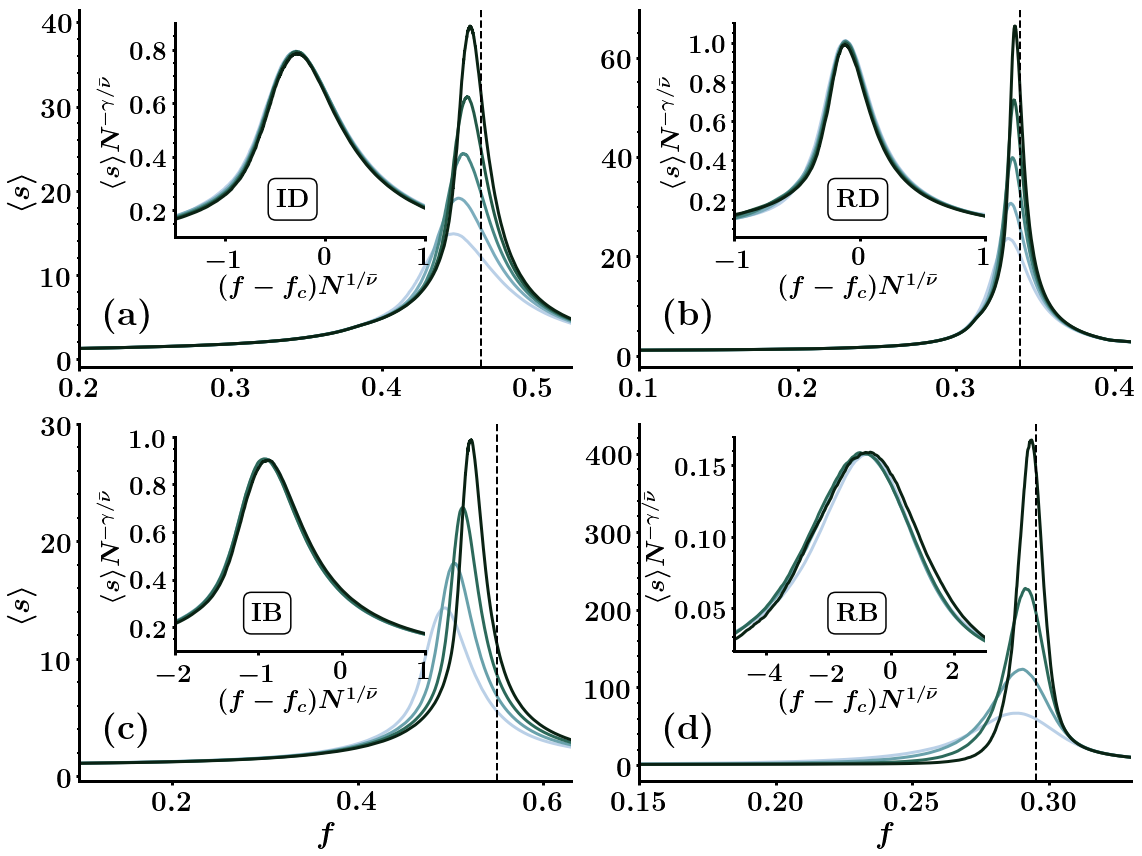

In [159]:
def plot_meanS_scaling(fc_values, beta_over_nu_values, nu_values):

    ncols = 2
    nrows = 2
    fig, axes = plt.subplots(figsize=(8*ncols, 6*ncols), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    attacks = ['Deg', 'DegU', 'Btw', 'BtwU']
    for j, attack in enumerate(attacks):
        
        if attack == 'Deg':
            N_values = [4000, 8000, 16000, 32000, 64000]
            fc = 0.4653
            fmin = 0.44
            fmax = 0.49
            beta_over_nu = 0.32
            nu = 2.7
        elif attack == 'DegU':
            N_values = [4000, 8000, 16000, 32000, 64000]
            fc = 0.3395
            fmin = 0.334
            fmax = 0.345
            beta_over_nu = 0.305
            nu = 2.3
        elif attack == 'Btw':
            N_values = [4000, 8000, 16000, 32000]
            fc = 0.55
            fmin = 0.5
            fmax = 0.6
            beta_over_nu = 0.333
            nu = 3.0
        elif attack == 'BtwU':
            N_values = [1000, 2000, 4000, 8000]
            fc = 0.2965
            fmin = 0.28
            fmax = 0.32
            #beta_over_nu = 0.12
            beta_over_nu = 0.095 
            nu = 1.5

        meank = 5
        _, _, _, dfs = load_dfs(attack, N_values, meank)
        
        ax = axes[j]

        if attack == 'Deg':
            fmin = 0.2
            fmax = 0.525
            ymin = 0
            ymax = 0.55   
            bbox_to_anchor = (.6, .5, .4, .48)
            box_place = (0.4, 0.45)   

        if attack == 'DegU':
            fmin = 0.1
            fmax = 0.41
            ymin = 0
            ymax = 0.4
            bbox_to_anchor = (.6, .5, .4, .48)
            box_place = (0.4, 0.45)   
            
        if attack == 'Btw':
            fmin = 0.1
            fmax = 0.63
            ymin = 0
            ymax = 0.7
            bbox_to_anchor = (.16, .24, .4, .44)
            box_place = (0.35, 0.45)   
            
        if attack == 'BtwU':
            fmin = 0.15
            fmax = 0.33
            ymin = 0
            ymax = 0.765
            bbox_to_anchor = (.16, .24, .4, .44)
            box_place = (0.4, 0.45)   
                      
        #ax.set_ylim(ymin, ymax)
        ax.set_xlim(fmin, fmax)
        
        if j in [0, 2]:
            ax.set_ylabel(r'$\langle s \rangle$')
        if j in [2, 3]:
            ax.set_xlabel(r'$f$')

        _N_values = list(dfs.keys())
        colors = sns.cubehelix_palette(len(_N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
        
        for i, N in enumerate(_N_values):
            df = dfs[N]
            ax.plot(df.f, df.meanS, '-', color=colors[i])
        
        
        bbox_to_anchor = (.22, .4, .51, .6)
        axins = inset_axes(ax, width="100%", height="100%",
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=ax.transAxes)
        axins.patch.set_alpha(0.)
        
        axins.tick_params(labelsize=26)
        if attack == 'Deg':
            pass
            axins.set_xlim(-1.5, 1)
            axins.set_ylim(0.1, 0.9)
        elif attack == 'DegU':
            axins.set_xlim(-1., 1.)
            axins.set_ylim(0.01, 1.1)
            axins.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
        elif attack == 'Btw':
            axins.set_xlim(-2., 1.)
            axins.set_ylim(0.1, 1)
            axins.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
        elif attack == 'BtwU':
            #axins.set_xlim(-1., 2.)
            axins.set_xlim(-5., 3.)
            axins.set_xticks([-4, -2, 0, 2])
            axins.set_ylim(0.02, 0.17)
            axins.set_yticks([0.05, 0.1, 0.15])

        if fc_values:
            fc = fc_values[attack]
        if gamma_over_nu_values:
            gamma_over_nu = beta_over_nu_values[attack]
        if nu_values:
            nu = nu_values[attack]
        print(attack, fc, beta_over_nu, nu)

        axins.set_xlabel(r'$(f-f_c) N^{1/\bar{\nu}}$', fontsize=26)
        axins.set_ylabel(r'$\langle s \rangle N^{-\gamma/\bar{\nu}}$', fontsize=26)      

        for i, N in enumerate(_N_values):  
            X = (dfs[N].f - fc)*N**(1/nu)
            Y = dfs[N].meanS*N**(-gamma_over_nu)
            axins.plot(X, Y, '-', color=colors[i])
        
        ax.axvline(fc, linestyle='--', color='k', linewidth=2)
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(*box_place, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        
        ax.text(0.05, 0.12, letters[j], fontsize=36, transform=ax.transAxes, 
                horizontalalignment='left')
        
    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'meanS_scaling')
    plt.savefig(fig_name + '.png'.format(N))
    plt.savefig(fig_name + '.pdf'.format(N))
    
    plt.show()
    
fc_values = {
    'Deg':  0.4653,
    'DegU': 0.339+0.001,
    'Btw':  0.55,
    'BtwU': 0.2954
}

gamma_over_nu_values = {
    'Deg':  0.354,
    'DegU': 0.38,
    'Btw':  0.33333,
    'BtwU': 0.876
}

nu_values =  {
    'Deg':  3.0,
    'DegU': 3.0,
    'Btw':  3.0,
    'BtwU': 1.5    
}

plot_meanS_scaling(fc_values, gamma_over_nu_values, nu_values)

0.4653 0.32 3.0
0.3395 0.305 3


/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


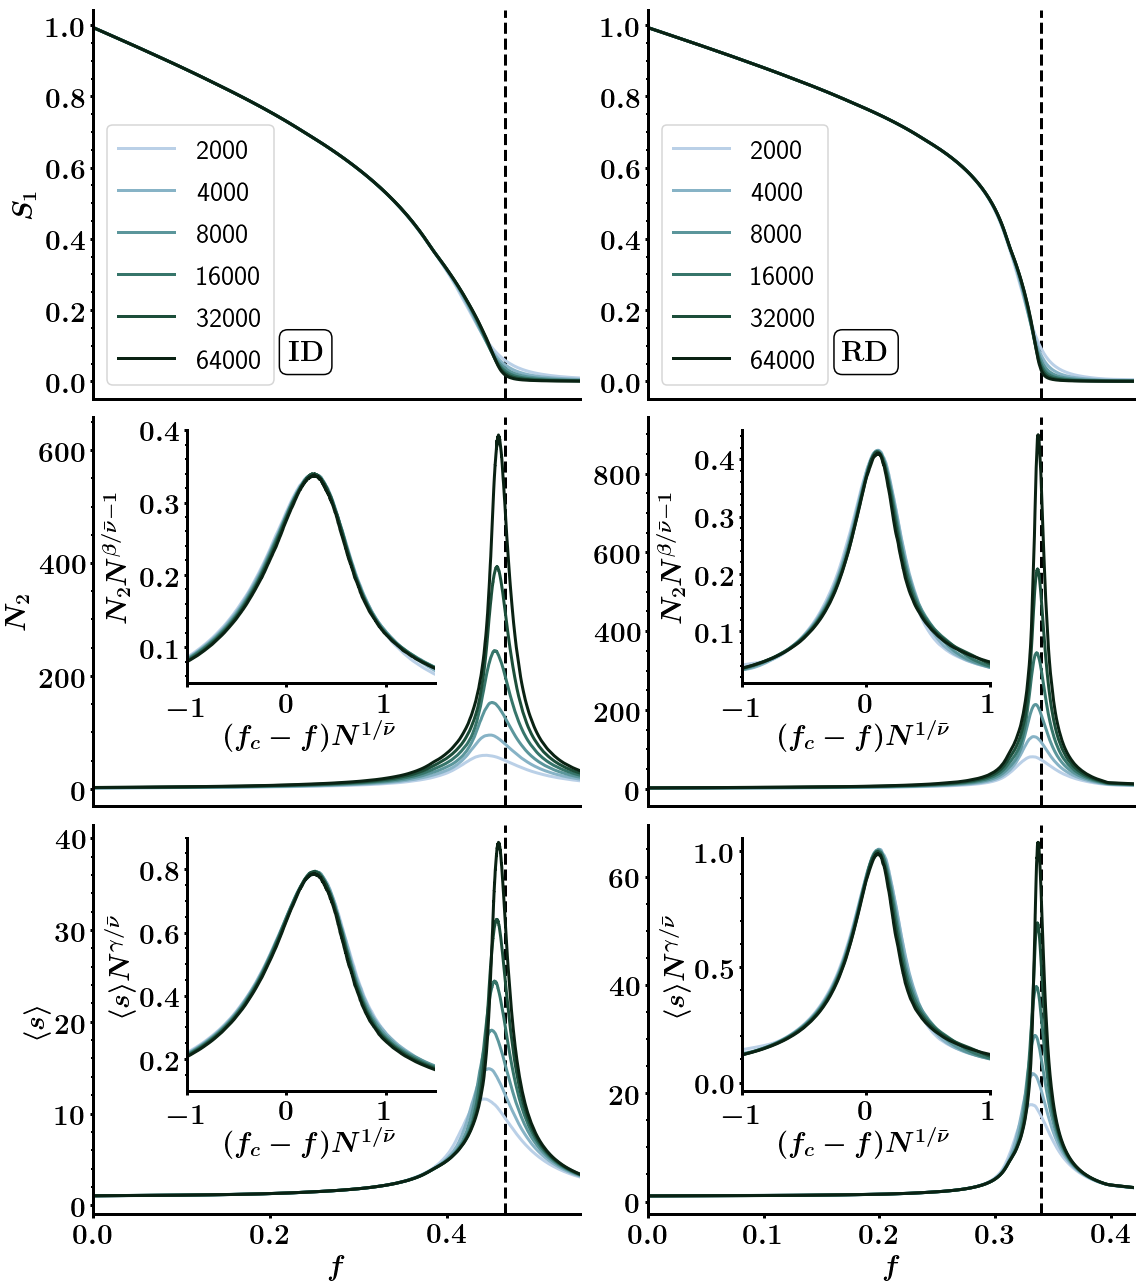

In [189]:
def plot_fig_fssa_deg_new(draw_box=False):

    dfs = {}
    
    ncols = 2
    nrows = 3
    fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    attacks = ['Deg', 'DegU']
    for i, attack in enumerate(attacks):
        
        if attack == 'Deg':
            N_values = [2000, 4000, 8000, 16000, 32000, 64000]
            fc_theo = 0.4653
            fmin = 0.44
            fmax = 0.49
        elif attack == 'DegU':
            N_values = [2000, 4000, 8000, 16000, 32000, 64000]
            fc_theo = 0.3395
            fmin = 0.334
            fmax = 0.345  
        
        dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, meank)
        dfs = {}
        _N_values = N_values
        for N in _N_values:
            dfs[N] = dfsMax[N]
        N_values = list(dfs.keys())
        
        colors = sns.cubehelix_palette(len(_N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
        
        for ax in axes[:,0].flatten():
            ax.set_xlim(0., 0.55)
        for ax in axes[:,1].flatten():
            ax.set_xlim(0., 0.42)
            
        if i == 0:
            beta_over_nu = 0.32
            gamma_over_nu = 0.354
            nu = 3.0
            beta = nu * beta_over_nu
            gamma = nu * gamma_over_nu
        else:
            beta_over_nu = 0.305
            gamma_over_nu = 0.38
            nu = 3
            beta = nu * beta_over_nu
            gamma = nu * gamma_over_nu
            
        fc = fc_theo
            
        beta_text = r"$\beta = {{{:.2f}}}$".format(beta)
        gamma_text = r"$\gamma = {{{:.2f}}}$".format(gamma)
        nu_text = r"$\nu = {{{:.2f}}}$".format(nu)
        fc_text = r"$f_c = {{{:.3f}}}$".format(fc)
        exponents_text = beta_text + '\n' + gamma_text + '\n' + nu_text + '\n' + fc_text
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        if draw_box:
            axes[0][i].text(0.3, 0.1, exponents_text, fontsize=22, 
                    transform=axes[0][i].transAxes, bbox=bbox)              
            
        for ax in axes[:,i]:
            ax.axvline(fc, linestyle='--', color='k')
            
        ax = axes[0][i]
        ax.set_xticks([])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        for j, N in enumerate(N_values):
            ax.plot(dfs[N].f, dfs[N].Sgcc, label='{}'.format(N), color=colors[j])
        if i == 0:
            ax.set_ylabel(r'$S_1$', fontsize=28)

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.4, 0.1, attack_dict[attack], fontsize=28, 
                transform=ax.transAxes, bbox=bbox)   

        ax.legend(loc="lower left", fontsize=28)
        
        
        ax = axes[1][i]
        ax.set_xticks([])
        for j, N in enumerate(N_values):
            ax.plot(dfs[N].f, dfs[N].Nsec, color=colors[j])
        ## Inset
        bbox_to_anchor = (.22, .35, .51, .65)
        axins = inset_axes(ax, width="100%", height="100%",
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=ax.transAxes)
        #axins.set_xticks([])
        #axins.set_yticks([])

        if i == 0:
            axins.set_xlim(-1., 1.5)
            axins.set_ylim(0.05, 0.4)
        else:
            axins.set_xlim(-1., 1.)
            axins.set_ylim(0.01, 0.45)
            axins.set_yticks([0.1, 0.2, 0.3, 0.4])
        axins.set_xlabel(r'$(f_c-f) N^{1/\bar{\nu}}$', fontsize=28)
        axins.set_ylabel(r'$N_2 N^{\beta/\bar{\nu}-1}$', fontsize=28)
        for j, N in enumerate(N_values):    
            X = (fc - dfs[N].f)*N**(1/nu)
            Y = dfs[N].Nsec*N**(beta_over_nu-1)
            axins.plot(X, Y, '-', color=colors[j])
            
        if i == 0:
            ax.set_ylabel(r'$N_2$', fontsize=28)
        
        ax = axes[2][i]
        for j, N in enumerate(N_values):
            ax.plot(dfs[N].f, dfs[N].meanS, color=colors[j])
        if i == 0:
            ax.set_ylabel(r'$\langle s \rangle $', fontsize=28)
        
        ## Inset
        bbox_to_anchor = (.22, .35, .51, .65)
        axins = inset_axes(ax, width="100%", height="100%",
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=ax.transAxes)
        #axins.set_xticks([])
        #axins.set_yticks([])
        if i == 0:
            axins.set_xlim(-1., 1.5)
            axins.set_ylim(0.1, 0.9)
            axins.set_yticks([0.2, 0.4, 0.6, 0.8])
        else:
            axins.set_xlim(-1., 1.)
        axins.set_xlabel(r'$(f_c-f) N^{1/\bar{\nu}}$', fontsize=28)
        axins.set_ylabel(r'$\langle s \rangle N^{-\gamma/\bar{\nu}}$', fontsize=28)
        for j, N in enumerate(N_values):    
            X = (fc - dfs[N].f)*N**(1/nu)
            Y = dfs[N].meanS*N**(-gamma_over_nu)
            axins.plot(X, Y, '-', color=colors[j])
        print(fc, beta_over_nu, nu)   
        ax.set_xlabel(r'$f$', fontsize=28)
        
    sns.despine()
    plt.tight_layout()

    plt.savefig(os.path.join(fig_dir, 'Deg_fssa_fc_scaled.png'))
    plt.savefig(os.path.join(fig_dir, 'Deg_fssa_fc_scaled.pdf'))
    plt.show()

plot_fig_fssa_deg_new()

/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


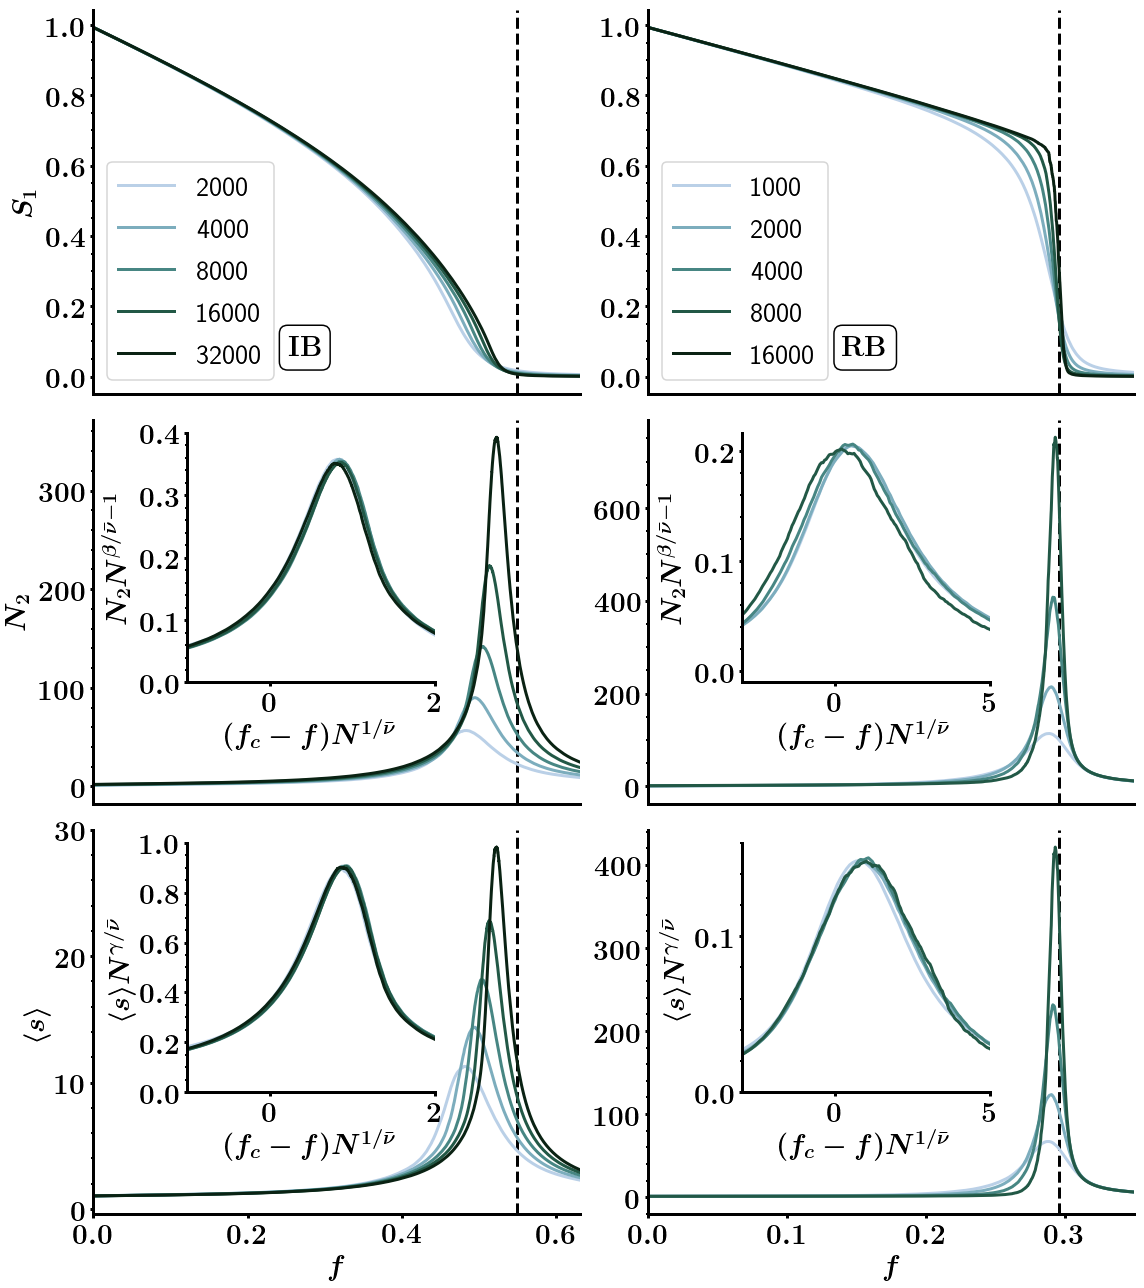

In [156]:
def plot_fig_fssa_btw_new(nu_btwU=None, draw_box=False):

    dfs = {}
    
    ncols = 2
    nrows = 3
    fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    attacks = ['Btw', 'BtwU']
    for i, attack in enumerate(attacks):
        
        if attack == 'Btw':
            N_values = [2000, 4000, 8000, 16000, 32000]
            fc_theo = 0.5475 + 0.002
            tolerance = fc_theo/500
            fmin = 0.5
            fmax = 0.6
        elif attack == 'BtwU':
            N_values = [1000, 2000, 4000, 8000, 16000]
            fc_theo = 0.2975 - 0.0017
            tolerance = fc_theo/500
            fmin = 0.28
            fmax = 0.32
        
        dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, meank)
        dfs = {}
        _N_values = N_values
        for N in _N_values:
            dfs[N] = dfsMax[N]
        N_values = list(dfs.keys())
        
        colors = sns.cubehelix_palette(len(_N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
        
        for ax in axes[:,0].flatten():
            ax.set_xlim(0., 0.63)
        for ax in axes[:,1].flatten():
            ax.set_xlim(0., 0.35)
            
        if i == 0:
            beta_over_nu = 0.33333
            gamma_over_nu = 0.33333
            nu = 3.0
            beta = nu * beta_over_nu
            gamma = nu * gamma_over_nu
        else:
            #beta_over_nu = 0.12
            beta_over_nu = 0.095 - 0.01
            #gamma_over_nu = 0.855
            gamma_over_nu = 0.875 + 0.01
            if nu_btwU:
                nu = nu_btwU
            else:
                nu = 5.0
            beta = nu * beta_over_nu
            gamma = nu * gamma_over_nu
            
        fc = fc_theo
            
        beta_text = r"$\beta = {{{:.2f}}}$".format(beta)
        gamma_text = r"$\gamma = {{{:.2f}}}$".format(gamma)
        nu_text = r"$\nu = {{{:.2f}}}$".format(nu)
        fc_text = r"$f_c = {{{:.3f}}}$".format(fc)
        exponents_text = beta_text + '\n' + gamma_text + '\n' + nu_text + '\n' + fc_text
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        if draw_box:
            axes[0][i].text(0.3, 0.1, exponents_text, fontsize=22, 
                    transform=axes[0][i].transAxes, bbox=bbox)              
            
        for ax in axes[:,i]:
            ax.axvline(fc, linestyle='--', color='k')
            
        ax = axes[0][i]
        ax.set_xticks([])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        for j, N in enumerate(N_values):
            ax.plot(dfs[N].f, dfs[N].Sgcc, label='{}'.format(N), color=colors[j])
        if i == 0:
            ax.set_ylabel(r'$S_1$', fontsize=28)

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.4, 0.1, attack_dict[attack], fontsize=28, 
                transform=ax.transAxes, bbox=bbox)   

        ax.legend(loc="lower left", fontsize=28)
        
        if i == 1:
            N_values.remove(16000)
        
        ax = axes[1][i]
        ax.set_xticks([])
        for j, N in enumerate(N_values):
            ax.plot(dfs[N].f, dfs[N].Nsec, color=colors[j])
        ## Inset
        bbox_to_anchor = (.22, .35, .51, .65)
        axins = inset_axes(ax, width="100%", height="100%",
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=ax.transAxes)
        #axins.set_xticks([])
        #axins.set_yticks([])

        if i == 0:
            axins.set_xlim(-1., 2.)
            axins.set_ylim(0., 0.4)
        else:
            #axins.set_xlim(-1., 2.)
            axins.set_xlim(-3., 5.)
            #axins.set_ylim(, 0.3)
        axins.set_xlabel(r'$(f_c-f) N^{1/\bar{\nu}}$', fontsize=28)
        axins.set_ylabel(r'$N_2 N^{\beta/\bar{\nu}-1}$', fontsize=28)
        for j, N in enumerate(N_values):    
            X = (fc - dfs[N].f-0.002)*N**(1/nu)
            Y = dfs[N].Nsec*N**(beta_over_nu-1)
            axins.plot(X, Y, '-', color=colors[j])
            
        if i == 0:
            ax.set_ylabel(r'$N_2$', fontsize=28)
        
        ax = axes[2][i]
        for j, N in enumerate(N_values):
            ax.plot(dfs[N].f, dfs[N].meanS, color=colors[j])
        if i == 0:
            ax.set_ylabel(r'$\langle s \rangle $', fontsize=28)
        
        ## Inset
        bbox_to_anchor = (.22, .35, .51, .65)
        axins = inset_axes(ax, width="100%", height="100%",
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=ax.transAxes)
        #axins.set_xticks([])
        #axins.set_yticks([])
        if i == 0:
            axins.set_xlim(-1., 2.)
            axins.set_ylim(0.0, 1)
            axins.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        else:
            #axins.set_xlim(-1., 2.)
            axins.set_ylim(0.0, 0.16)
            axins.set_yticks([0,0.1])            
            axins.set_xlim(-3., 5.)
        axins.set_xlabel(r'$(f_c-f) N^{1/\bar{\nu}}$', fontsize=28)
        axins.set_ylabel(r'$\langle s \rangle N^{-\gamma/\bar{\nu}}$', fontsize=28)
        for j, N in enumerate(N_values):    
            X = (fc - dfs[N].f)*N**(1/nu)
            Y = dfs[N].meanS*N**(-gamma_over_nu)
            axins.plot(X, Y, '-', color=colors[j])
            
        ax.set_xlabel(r'$f$', fontsize=28)
        
    sns.despine()
    plt.tight_layout()

    plt.savefig(os.path.join(fig_dir, 'Btw_fssa_fc_scaled.png'))
    plt.savefig(os.path.join(fig_dir, 'Btw_fssa_fc_scaled.pdf'))
    plt.show()

for nu_btwU in [1.5]:
    plot_fig_fssa_btw_new(nu_btwU)